# 제품 판매량 예측

## 1. 개요

**선정 이유**
- 데이콘(국내 캐글) 플랫폼의 데이터 및 프로세스를 경험함으로써 데이터 분석 프로젝트의 전반적인 지식 습득과 

**목표**
- 제주도의 주요 특산물(양배추, 월동무, 당근, 브로콜리, 감귤)의 가격을 정확하고 효율적으로 예측하는 AI 모델 개발
- 가격 변동에 대한 깊이 있는 인사이트 제공 및 관련 솔루션 제시

**중요성**
- 제주도 특산물의 안정적 수급과 가격 관리를 위한 예측 모델이 필요
- 농가와 소비자 모두에게 혜택을 주는 경제적, 사회적 가치 창출

**프로젝트 수행 일정**
1. **기획 및 준비 단계**
   - 프로젝트 범위 설정, 목표 확정, 역할 설정

2. **데이터 수집 및 전처리**
   - 필요한 데이터 수집, 정제, 전처리 작업 수행

3. **모델 개발 및 테스트**
   - 다양한 예측 모델 설계, 테스트 및 최적화

4. **인사이트 분석 및 보고서 작성**
   - 모델 결과 해석, 인사이트 도출 및 보고서 작성

5. **결과 검토 및 프로젝트 마무리**
   - 최종 결과 검토, 프로젝트 평가 및 마무리

## 2. 데이터 준비

### 2.0. 함수 정의 및 설정하기

#### 기본 라이브러리 import

In [1]:
# conda install pandas numpy matplotlib seaborn scikit-learn holidays

In [2]:
# pip install darts xgboost lightgbm catboost hyperopt

In [3]:
import random
import pandas as pd
import numpy as np
import os
import warnings
import pickle as pkl

warnings.filterwarnings(action='ignore') 

In [4]:
import holidays

#### 시각화 라이브러리 import

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True

# settings for seaborn plot sizes
import platform
sns.set(rc={'figure.figsize':(20, 10)})

if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

#### 모델 라이브러리 import

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [7]:
from darts.timeseries import TimeSeries
from darts.models import DLinearModel, AutoARIMA

In [8]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import  LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

In [9]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [10]:
# import torch
# import torch.nn as nn

#### 시드 설정하기

In [11]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)  # type: ignore
    # torch.backends.cudnn.deterministic = True  # type: ignore
    # torch.backends.cudnn.benchmark = True  # type: ignore    

seed_everything(42) # Seed 고정

### 2.1. 데이터 정의

*독립/종속변수 설정*

#### 데이터 개요

1. train.csv 데이터셋 개요

- **기간**: 2019년 01월 01일부터 2023년 03월 03일까지
- **품목**:
  - TG: 감귤
  - BC: 브로콜리
  - RD: 무
  - CR: 당근
  - CB: 양배추
- **유통 법인 코드**: A부터 F까지 존재
- **지역 코드**: 
  - J: 제주도 제주시
  - S: 제주도 서귀포시
- **유통된 물량 (supply(kg))**: kg 단위
- **가격 (price(원/kg))**: kg당 가격, 원 단위

2. international_trade.csv 데이터셋 개요

- **기간**: 월 단위로 제공
- **품목명**: 다양한 농산물 (예: 토마토, 양파 등)
- **수출 중량**: kg 단위
- **수출 금액**: 천 달러 단위
- **수입 중량**: kg 단위
- **수입 금액**: 천 달러 단위
- **무역수지**: 수출 금액 - 수입 금액 (천 달러 단위)

#### 데이터 불러오기

In [13]:
base_path = './data/'

In [14]:
train_data = pd.read_csv(base_path + 'train.csv')
trade_data = pd.read_csv(base_path + 'international_trade.csv')

#### 데이터 확인하기

In [14]:
train_data.sample(5)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
2980,TG_A_S_20221228,2022-12-28,TG,A,S,53392.0,2552.0
5246,TG_B_S_20201108,2020-11-08,TG,B,S,0.0,0.0
22657,CR_D_S_20220828,2022-08-28,CR,D,S,0.0,0.0
58134,RD_F_J_20190918,2019-09-18,RD,F,J,0.0,0.0
13361,TG_E_J_20220323,2022-03-23,TG,E,J,0.0,0.0


In [15]:
trade_data.sample(5)

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
186,2019-08,오이류(신선한 것이나 냉장한 것으로 한정한다),1907,6,0,0,6
487,2020-08,대추야자,438,4,10416,48,-44
832,2021-10,방울다다기 양배추,0,0,30012,142,-142
223,2019-09,감귤,8050,39,0,0,39
1170,2022-10,자두,25,0,0,0,0


## 3. 데이터 분석

### 3.1. 탐색적 분석(EDA)

- *데이터 타입(연속형/범주형)*
- *독립-종속 변수 존재 유무 확인*
- *적용가능한 분석모델 파악(회귀/분류/군집화/비지도학습)*

#### train data 기본 정보 확인

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.2+ MB


In [17]:
train_data.sample(5)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
30039,CB_D_J_20220107,2022-01-07,CB,D,J,5500.0,297.0
9481,TG_D_J_20191210,2019-12-10,TG,D,J,43245.0,1184.0
32386,RD_A_J_20200208,2020-02-08,RD,A,J,14520.0,524.0
11147,TG_D_S_20200501,2020-05-01,TG,D,S,300.0,5367.0
1592,TG_A_S_20190311,2019-03-11,TG,A,S,22112.0,4764.0


**Total Result**
- 59,397개의 행, 7개의 열 존재
- null 값 존재하지 않음
- `ID` 정보에는 `timestamp`, `item`, `corporation`, `location`의 정보를 가지고 있음

**Insight**
> 실제 시스템에서 모델을 적용하기 위해서 기본 x 변수를 ID로만 설정하고, 해당 ID를 기준으로 다양한 변수들을 생성하여 제품 가격을 예측하는 방식으로 진행하려고 한다.
- ID를 기준으로 다양한 feature을 추출 및 전처리하는 과정 함수화

#### 각 칼럼 별 데이터 분포 확인

In [18]:
# 각 컬럼별 unique 갯수 확인
for col in train_data.columns:
    print(col, train_data[col].nunique())

ID 59397
timestamp 1523
item 5
corporation 6
location 2
supply(kg) 12521
price(원/kg) 7094


- `ID`는 unique한 변수
- `timestamp` 칼럼은 시계열 변수로 나중에 datetime type으로 변경
  - unique 갯수 상, 동일한 시간대의 데이터 존재 예상
  - 해당 unique 변수들이 데이터 기간 모두를 포함하는지 분석 필요(2019년 01월 01일부터 2023년 03월 03일까지)
- `item`, `corporation`, `location` 칼럼들은 일반적인 category type, 나중에 인코딩 과정 필요

In [19]:
# timestamp 칼럼 변수들이 데이터 기간 모두를 포함하는지 확인(2019년 01월 01일부터 2023년 03월 03일까지)
print('train_data timestamp min : ', train_data['timestamp'].min())
print('train_data timestamp max : ', train_data['timestamp'].max())

train_data timestamp min :  2019-01-01
train_data timestamp max :  2023-03-03


In [20]:
from datetime import datetime, timedelta

# 전체 기간(2019년 01월 01일부터 2023년 03월 03일까지)에서 timestamp 칼럼 unique 값 중 빠진 날짜 확인

# Convert the sample timestamps to datetime objects
timestamps = [datetime.strptime(date, "%Y-%m-%d") for date in train_data['timestamp'].unique()]

# Define the start and end dates of the period
start_date = datetime(2019, 1, 1)
end_date = datetime(2023, 3, 3)

# Generate a list of all dates in the period
all_dates = {start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)}

# Find the missing dates
missing_dates = sorted(all_dates - set(timestamps))

print(missing_dates)


# 빠진 날짜 확인, 2019년 01월 01일부터 2023년 03월 03일까지 1일씩 증가하는 날짜가 1523개가 되어야 함
print('train_data timestamp unique : ', train_data['timestamp'].nunique())
print('all_dates : ', len(all_dates))   

[]
train_data timestamp unique :  1523
all_dates :  1523


<Axes: xlabel='timestamp', ylabel='price(원/kg)'>

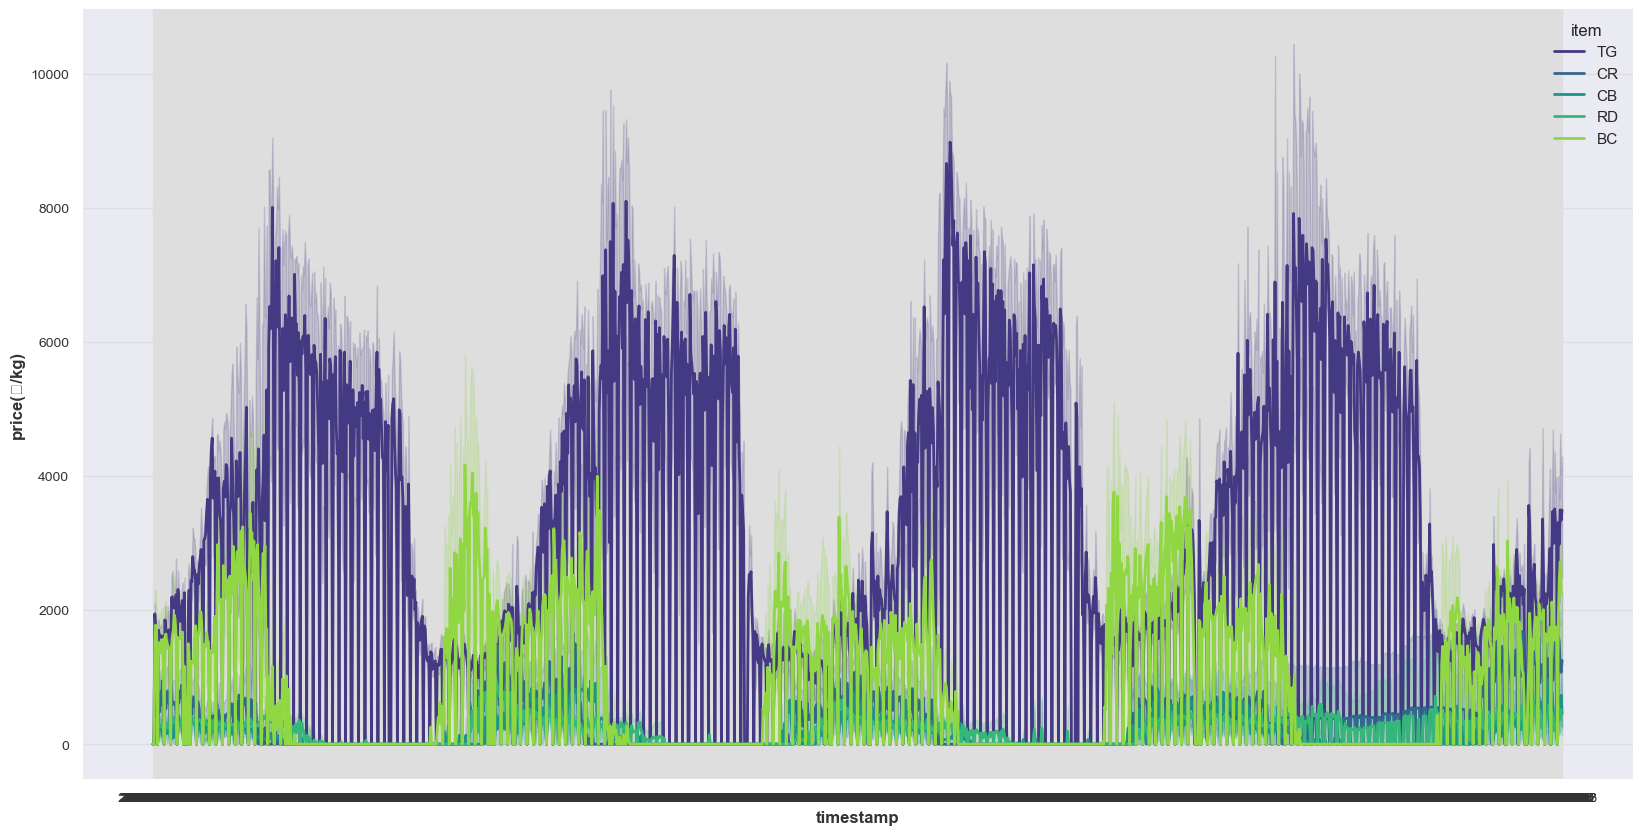

In [21]:
sns.lineplot(x='timestamp', y='price(원/kg)', hue='item', data=train_data, palette='viridis', linewidth=2)

item ['TG' 'CR' 'CB' 'RD' 'BC']
corporation ['A' 'B' 'C' 'D' 'E' 'F']
location ['J' 'S']


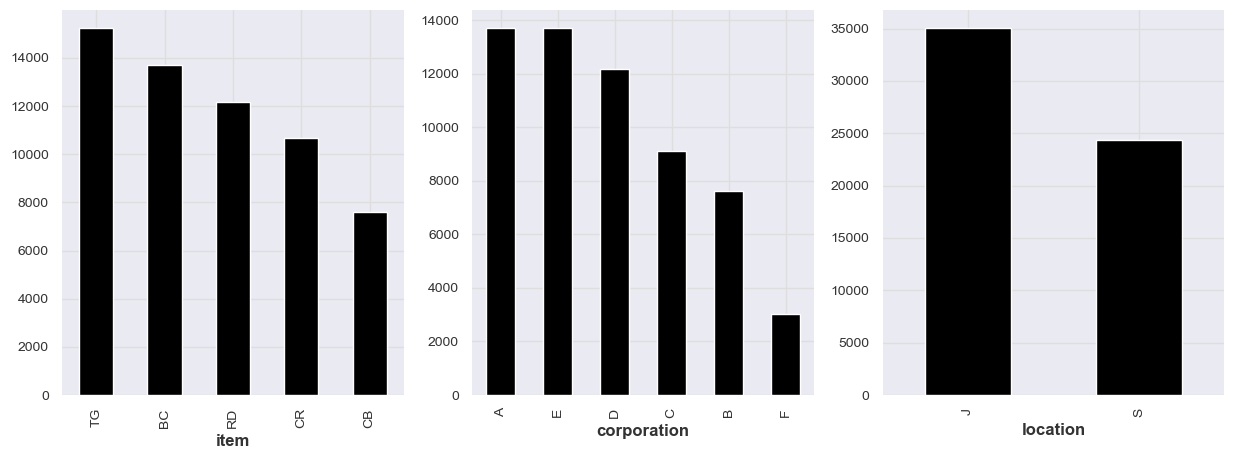

In [22]:
# 각 컬럼별(item, corporation, location) unique 종류 확인
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(['item', 'corporation', 'location']):
    print(col, train_data[col].unique())
    train_data[col].value_counts().plot(kind='bar', ax=axes[i])

In [23]:
pd.pivot_table(train_data, index='item', columns='corporation',
               values='price(원/kg)', aggfunc='median')

corporation,A,B,C,D,E,F
item,,,,,,
BC,0.0,0.0,0.0,0.0,0.0,NaN
CB,0.0,NaN,NaN,0.0,0.0,0.0
CR,0.0,0.0,0.0,0.0,0.0,NaN
RD,0.0,NaN,0.0,0.0,0.0,292.0
TG,2228.0,2396.0,2854.5,2129.5,1790.5,NaN


In [24]:
pd.pivot_table(train_data, index='item', columns='corporation',
               values='price(원/kg)', aggfunc='mean')

corporation,A,B,C,D,E,F
item,,,,,,
BC,1315.576822,495.778398,474.738674,1192.342088,1213.619829,NaN
CB,104.713395,NaN,NaN,106.405121,186.241628,258.862114
CR,622.192383,173.214051,278.513460,214.087328,204.869009,NaN
RD,294.135588,NaN,5.846356,181.058109,140.486540,259.381484
TG,3112.148063,3279.455023,3788.332896,3056.239002,2651.035128,NaN


In [25]:
pd.pivot_table(train_data, index='item', columns='corporation',
               values='price(원/kg)', aggfunc='count')

corporation,A,B,C,D,E,F
item,,,,,,
BC,3046.0,3046.0,3046.0,1523.0,3046.0,NaN
CB,3046.0,NaN,NaN,1523.0,1523.0,1523.0
CR,1523.0,1523.0,1523.0,3046.0,3046.0,NaN
RD,3046.0,NaN,1523.0,3046.0,3046.0,1523.0
TG,3046.0,3046.0,3046.0,3046.0,3046.0,NaN


- 값 갯수가 1523인 경우는 location이 1개인 경우, 3046인 경우는 location이 2개인 경우
- 즉, 각 corporation, item, location 별로 1523개의 데이터가 존재하던가 값이 없음

In [26]:
# Object 칼럼들을 행과 열로하는 pivot table 생성, 값은 count(갯수)
# 칼럼 두 개를 선정 후, 각 칼럼의 unique 종류를 행과 열로 하는 pivot table 생성
# 각 칼럼의 unique 종류가 10개 이하인 경우에만 생성
obj_cols = [col for col in train_data.columns 
            if (train_data[col].dtype == 'object') and (train_data[col].nunique() <= 10)]
obj_cols

['item', 'corporation', 'location']

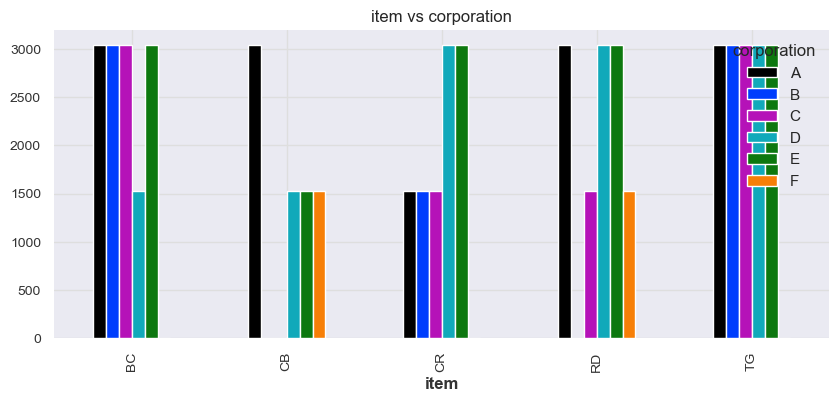

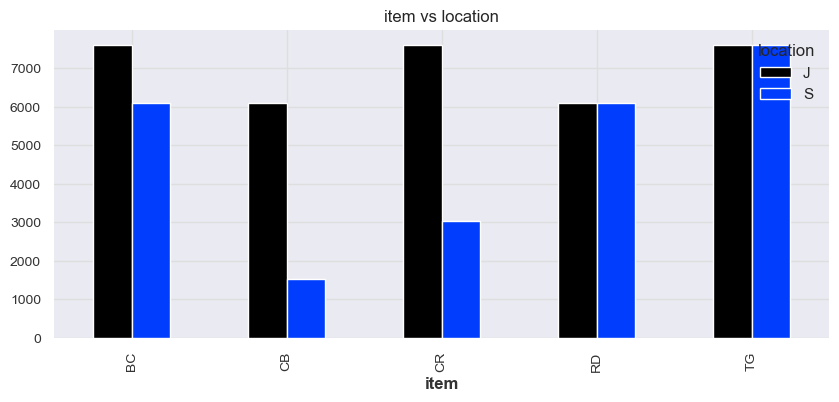

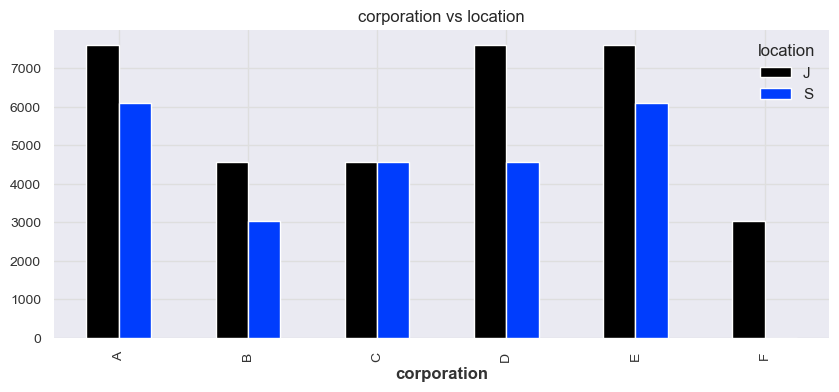

In [27]:
for i, col in enumerate(obj_cols):
    for j, col2 in enumerate(obj_cols):
        if i < j:
            pd.pivot_table(train_data,
                           index=col,
                           columns=col2,
                           values='ID',
                           aggfunc='count').plot(kind='bar', figsize=(10, 4))
            plt.title(f'{col} vs {col2}')

**Result**
- sss

In [28]:
# 수치형 칼럼들의 박스플롯
num_cols = [col for col in train_data.columns if train_data[col].dtype != 'object']
num_cols

['supply(kg)', 'price(원/kg)']

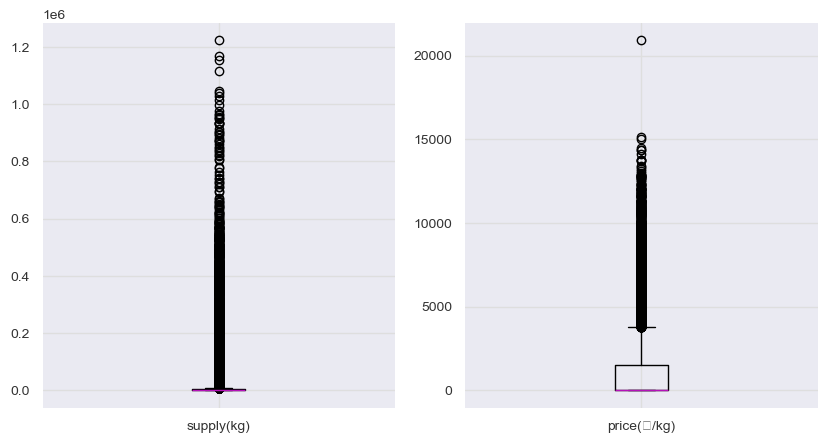

In [29]:
# num_cols의 칼럼들을 행으로 하는 박스플롯 생성
# 각 칼럼의 분포를 확인
fig, axes = plt.subplots(1, len(num_cols), figsize=(10, 5))
for i, col in enumerate(num_cols):
    train_data[col].plot(kind='box', ax=axes[i])

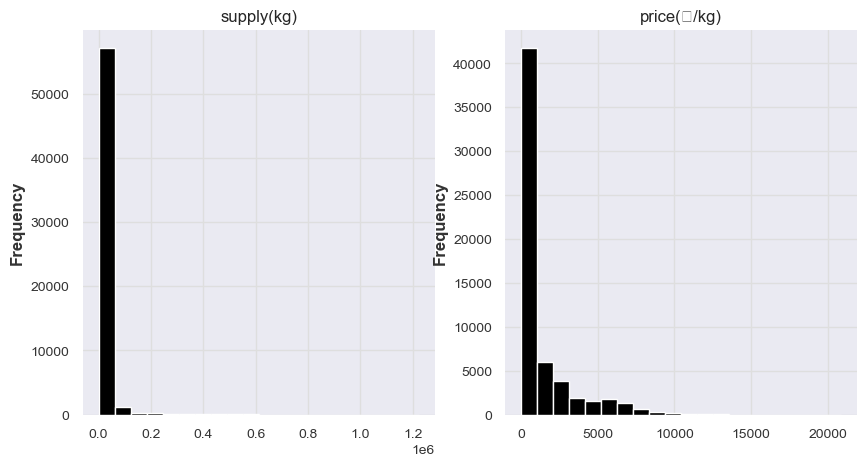

In [30]:
# 수치형 칼럼들의 히스토그램
fig, axes = plt.subplots(1, len(num_cols), figsize=(10, 5))
for i, col in enumerate(num_cols):
    train_data[col].plot(kind='hist', ax=axes[i], bins=20, title=col)

In [31]:
# 수치형 칼럼들의 value_counts의 탑 5
for col in num_cols:
    print(train_data[col].value_counts().head(5))

supply(kg)
0.0       35452
4300.0      181
8600.0       85
8620.0       84
200.0        83
Name: count, dtype: int64
price(원/kg)
0.0       35455
500.0        50
1000.0       45
550.0        42
400.0        41
Name: count, dtype: int64


In [32]:
cond_price_0 = train_data['price(원/kg)'] == 0
cond_supply_0 = train_data['supply(kg)'] != 0

train_data[cond_price_0 & cond_supply_0]

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
825,TG_A_J_20210405,2021-04-05,TG,A,J,64.0,0.0
9266,TG_D_J_20190509,2019-05-09,TG,D,J,129.0,0.0
31199,CB_E_J_20210109,2021-01-09,CB,E,J,80.0,0.0


In [32]:
# 수치형 칼럼들 중 값이 0인 비율
for col in num_cols:
    print(col, train_data[col].value_counts()[0] / len(train_data))

supply(kg) 0.5968651615401451
price(원/kg) 0.5969156691415392


- 예측해야 하는 target 칼럼의 분포 확인 결과, 0이 압도적으로 많음
- 0이 압도적으로 많은 경우, 0이 아닌 값들의 분포를 확인하기

#### price(원/kg) = 0 인 경우

In [577]:
# traom_data의 price(원/kg) 칼럼의 0인 값이 왜 발생했는지 확인
df_price_0 = train_data[train_data['price(원/kg)'] == 0]

In [578]:
# price(원/kg)가 0인 데이터들의 timestamp 칼럼의 unique 값 확인
df_price_0['timestamp'].nunique()

1523

In [579]:
# price(원/kg)가 0인 데이터들의 칼럼별 unique 값 확인
for col in df_price_0.columns:
    print(col, df_price_0[col].nunique())

ID 35455
timestamp 1523
item 5
corporation 6
location 2
supply(kg) 4
price(원/kg) 1


In [580]:
# price(원/kg)가 0인 데이터들의 item, corporation pivot table 생성
pivot_0 = pd.pivot_table(df_price_0, index='item', columns='corporation',
                         values='price(원/kg)', aggfunc='count')
pivot_0

corporation,A,B,C,D,E,F
item,,,,,,
BC,1688.0,2434.0,2454.0,856.0,1750.0,NaN
CB,2665.0,NaN,NaN,1245.0,1147.0,938.0
CR,1003.0,1315.0,1185.0,2543.0,2533.0,NaN
RD,1755.0,NaN,1499.0,1912.0,2258.0,720.0
TG,787.0,634.0,605.0,708.0,821.0,NaN


In [581]:
# 값은 전체 데이터 수와 비교해서 0인 비율
pivot_all = pd.pivot_table(train_data, index='item', columns='corporation',
                           values='price(원/kg)', aggfunc='count')
pivot_0 / pivot_all * 100

corporation,A,B,C,D,E,F
item,,,,,,
BC,55.416940,79.908076,80.564675,56.204859,57.452397,NaN
CB,87.491793,NaN,NaN,81.746553,75.311884,61.588969
CR,65.856861,86.342745,77.806960,83.486540,83.158240,NaN
RD,57.616546,NaN,98.424163,62.770847,74.130007,47.275115
TG,25.837163,20.814183,19.862114,23.243598,26.953381,NaN


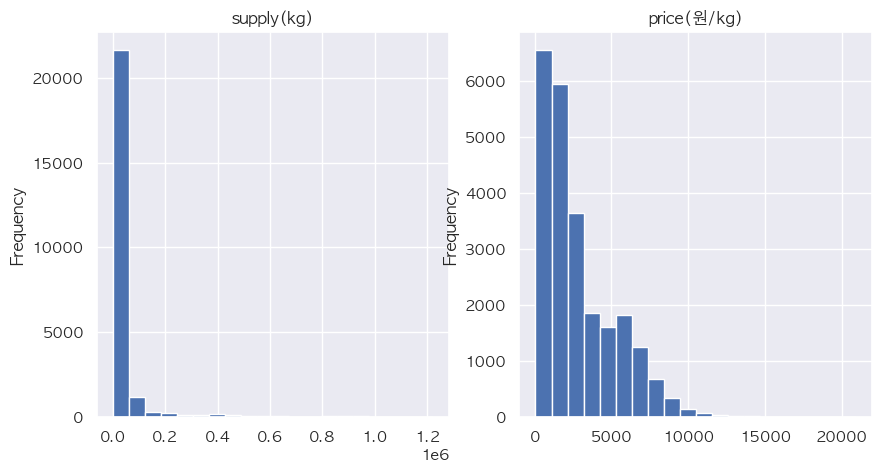

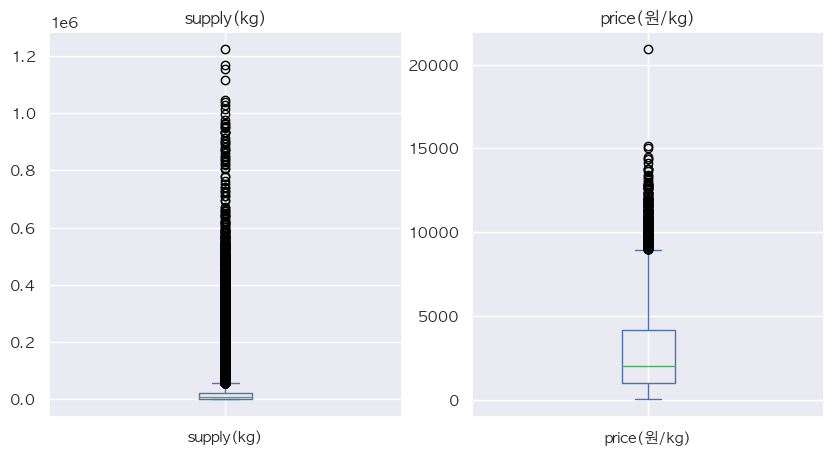

In [582]:
# 수치형 칼럼들의 히스토그램
fig1, axes1 = plt.subplots(1, len(num_cols), figsize=(10, 5))
fig2, axes2 = plt.subplots(1, len(num_cols), figsize=(10, 5))
for i, col in enumerate(num_cols):
    train_data[col][train_data[col] != 0].plot(kind='hist', ax=axes1[i], bins=20, title=col)
    train_data[col][train_data[col] != 0].plot(kind='box', ax=axes2[i], title=col)

**Result**
- sss

### 3.2. 특징 엔지니어링

- *특징 선택/추출/생성*
- *다중공선성 파악 및 차원 축소*

#### 데이터 복사(for 데이터 보존)

In [15]:
train_df = train_data.copy()
# trade_df = trade_data.copy()

In [16]:
train_df.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [17]:
train_df = train_df[['ID','price(원/kg)']]
train_df.columns = ['ID','price']

In [18]:
train_df.head()

,ID,price
0,TG_A_J_20190101,0.0
1,TG_A_J_20190102,0.0
2,TG_A_J_20190103,1728.0
3,TG_A_J_20190104,1408.0
4,TG_A_J_20190105,1250.0


#### 품목, 유통 법인, 지역코드 추출
- **품목**:
  - TG: 감귤
  - BC: 브로콜리
  - RD: 무
  - CR: 당근
  - CB: 양배추
- **유통 법인 코드**: A부터 F까지 존재
- **지역 코드**: 
  - J: 제주도 제주시
  - S: 제주도 서귀포시

In [18]:
def split_id(x):
    return x.split('_')

In [19]:
def extract_id(x):
    return x[0]

In [20]:
def pre_init_feature(df):
    """ID에서 품목, 유통법인코드, 지역코드 추출, 날짜 추출"""
    split_series = df['ID'].apply(split_id)
    df['item'] = split_series.apply(lambda x: x[0])
    df['corporation'] = split_series.apply(lambda x: x[1])
    df['location'] = split_series.apply(lambda x: x[2])
    df['ymd'] = split_series.apply(lambda x: x[3])

In [21]:
pre_init_feature(train_df)

In [22]:
train_df.sample(3)

,ID,price,item,corporation,location,ymd
30039,CB_D_J_20220107,297.0,CB,D,J,20220107
9481,TG_D_J_20191210,1184.0,TG,D,J,20191210
32386,RD_A_J_20200208,524.0,RD,A,J,20200208


#### 년, 월, 일 추출

- 시계열 특성을 학습에 반영하기 위해 timestamp를 년, 월, 일으로 나눕니다

In [23]:
def pre_ymd(df):
    # year, month, day 생성
    df['year'] = df['ymd'].apply(lambda x : int(x[:4]))
    df['month'] = df['ymd'].apply(lambda x : int(x[4:6]))
    df['day'] = df['ymd'].apply(lambda x : int(x[6:]))

In [24]:
pre_ymd(train_df)

In [25]:
train_df.sample(3).T

,55906,5515,50259
ID,BC_E_S_20211214,TG_B_S_20210804,BC_C_S_20190101
price,2955.0,5350.0,0.0
item,BC,TG,BC
corporation,E,B,C
location,S,S,S
ymd,20211214,20210804,20190101
year,2021,2021,2019
month,12,8,1
day,14,4,1


#### ts(datetime type) 생성

In [26]:
def pre_timestamp(df):
    """year, month, day 칼럼을 사용하여 datetime 형식인 ts 칼럼 생성"""
    df['ts'] = df.apply(lambda x : pd.Timestamp(year=x.year,
                                                month=x.month,
                                                day=x.day),axis=1)

In [27]:
pre_timestamp(train_df)

In [28]:
train_df.sample(3).T

,44421,41811,20709
ID,BC_A_S_20190912,RD_E_S_20201121,CR_D_J_20210629
price,0.0,0.0,0.0
item,BC,RD,CR
corporation,A,E,D
location,S,S,J
ymd,20190912,20201121,20210629
year,2019,2020,2021
month,9,11,6
day,12,21,29
ts,2019-09-12 00:00:00,2020-11-21 00:00:00,2021-06-29 00:00:00


#### 주말(weekday) 변수 추가

- 0 ~ 6 : 월 ~ 일

In [29]:
def pre_weekday(df):
    """ts 칼럼을 사용하여 weekday 칼럼 생성"""
    df['weekday'] = df['ts'].dt.weekday

In [30]:
pre_weekday(train_df)

In [31]:
train_df.sample(3).T

,20939,18402,58081
ID,CR_D_J_20220214,CR_C_J_20190507,RD_F_J_20190727
price,759.0,0.0,0.0
item,CR,CR,RD
corporation,D,C,F
location,J,J,J
ymd,20220214,20190507,20190727
year,2022,2019,2019
month,2,5,7
day,14,7,27
ts,2022-02-14 00:00:00,2019-05-07 00:00:00,2019-07-27 00:00:00


#### 공휴일(holiday) 변수 추가

- EDA 결과, 일요일인 경우, 값에 이상치가 있다고 판단
- 일요일과 대한민국 공휴일을 공휴일로 판단하기

In [32]:
def pre_holiday(df):
    """ts 칼럼을 사용하여 holiday 칼럼 생성"""
    kr_holidays = holidays.KR()
    df['holiday'] = df['weekday'].apply(lambda x : 1 if x == 6 else 0)
    df['holiday'] = df.apply(lambda x : 1 if x.ts in kr_holidays
                                        else x.holiday, axis=1)

In [33]:
pre_holiday(train_df)

In [34]:
train_df.sample(3).T

,6480,6713,49312
ID,TG_C_J_20200124,TG_C_J_20200913,BC_C_J_20200730
price,2496.0,0.0,0.0
item,TG,TG,BC
corporation,C,C,C
location,J,J,J
ymd,20200124,20200913,20200730
year,2020,2020,2020
month,1,9,7
day,24,13,30
ts,2020-01-24 00:00:00,2020-09-13 00:00:00,2020-07-30 00:00:00


In [35]:
train_df.sample(3)

,ID,price,item,corporation,location,ymd,year,month,day,ts,weekday,holiday
45731,BC_B_J_20190211,1623.0,BC,B,J,20190211,2019,2,11,2019-02-11,0,0
18384,CR_C_J_20190419,0.0,CR,C,J,20190419,2019,4,19,2019-04-19,4,0
28162,CB_A_S_20210118,0.0,CB,A,S,20210118,2021,1,18,2021-01-18,0,0


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           59397 non-null  object        
 1   price        59397 non-null  float64       
 2   item         59397 non-null  object        
 3   corporation  59397 non-null  object        
 4   location     59397 non-null  object        
 5   ymd          59397 non-null  object        
 6   year         59397 non-null  int64         
 7   month        59397 non-null  int64         
 8   day          59397 non-null  int64         
 9   ts           59397 non-null  datetime64[ns]
 10  weekday      59397 non-null  int32         
 11  holiday      59397 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4), object(5)
memory usage: 5.2+ MB


### 3.3. feature engineering 시각화

#### month 별 price 평균값 및 중앙값

In [54]:
# month 별로 price의 평균값을 구함
month_price_mean = train_df.groupby('month')['price'].mean()
month_price_median = train_df.groupby('month')['price'].median()

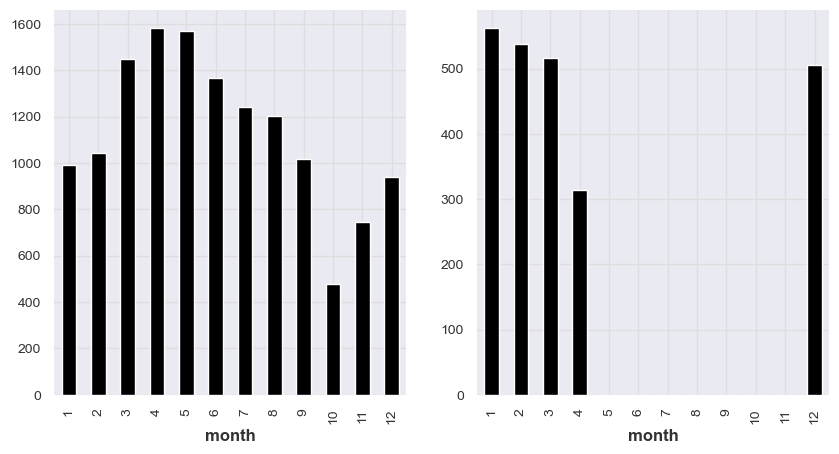

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
month_price_mean.plot(kind='bar', ax=axes[0])
month_price_median.plot(kind='bar', ax=axes[1])
plt.show()

#### day 별 price 평균값 및 중앙값

In [56]:
#### day 별 price 평균값 및 중앙값
day_price_mean = train_df.groupby('day')['price'].mean()
day_price_median = train_df.groupby('day')['price'].median()

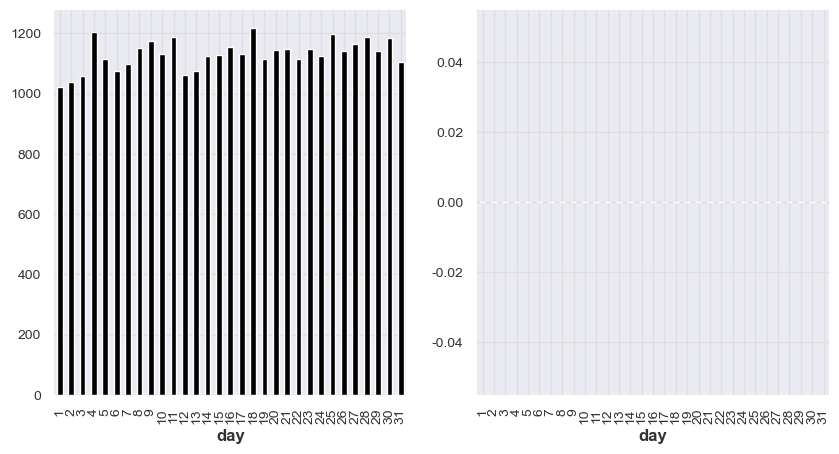

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
day_price_mean.plot(kind='bar', ax=axes[0])
day_price_median.plot(kind='bar', ax=axes[1])
plt.show()

#### Weekday 별 price 평균값 및 중앙값

In [58]:
#### weekday 별 price 평균값 및 중앙값
weekday_price_mean = train_df.groupby('weekday')['price'].mean()
weekday_price_median = train_df.groupby('weekday')['price'].median()

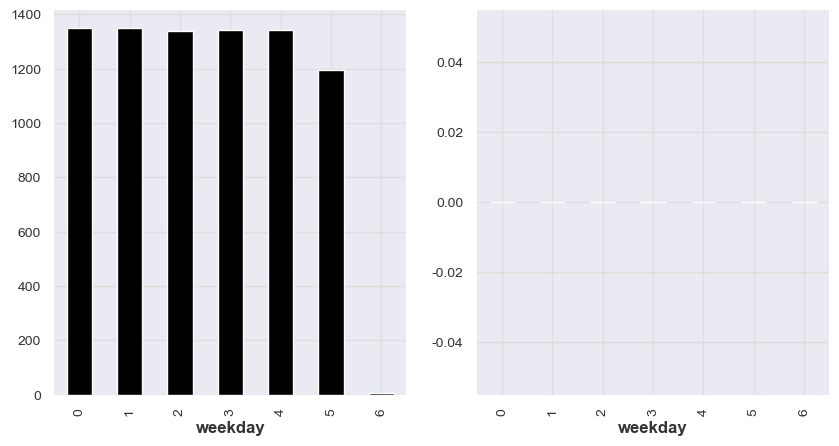

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
weekday_price_mean.plot(kind='bar', ax=axes[0])
weekday_price_median.plot(kind='bar', ax=axes[1])
plt.show()

In [60]:
weekday_price_mean

weekday
0    1349.425381
1    1349.847212
2    1338.040461
3    1340.132322
4    1341.594684
5    1194.993501
6       3.846863
Name: price, dtype: float64

#### holiday 별 price 평균값 및 중앙값

In [58]:
# holiday 별 price 평균값 및 중앙값
holiday_price_mean = train_df.groupby('holiday')['price'].mean()
holiday_price_median = train_df.groupby('holiday')['price'].median()

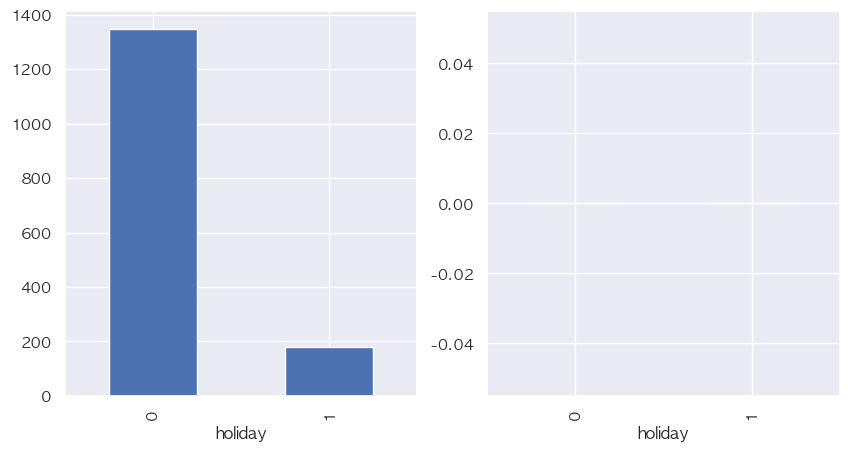

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
holiday_price_mean.plot(kind='bar', ax=axes[0])
holiday_price_median.plot(kind='bar', ax=axes[1])
plt.show()

In [60]:
train_df.head().T

,0,1,2,3,4
ID,TG_A_J_20190101,TG_A_J_20190102,TG_A_J_20190103,TG_A_J_20190104,TG_A_J_20190105
price,0.0,0.0,1728.0,1408.0,1250.0
item,TG,TG,TG,TG,TG
corporation,A,A,A,A,A
location,J,J,J,J,J
ymd,20190101,20190102,20190103,20190104,20190105
year,2019,2019,2019,2019,2019
month,1,1,1,1,1
day,1,2,3,4,5
ts,2019-01-01 00:00:00,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-05 00:00:00


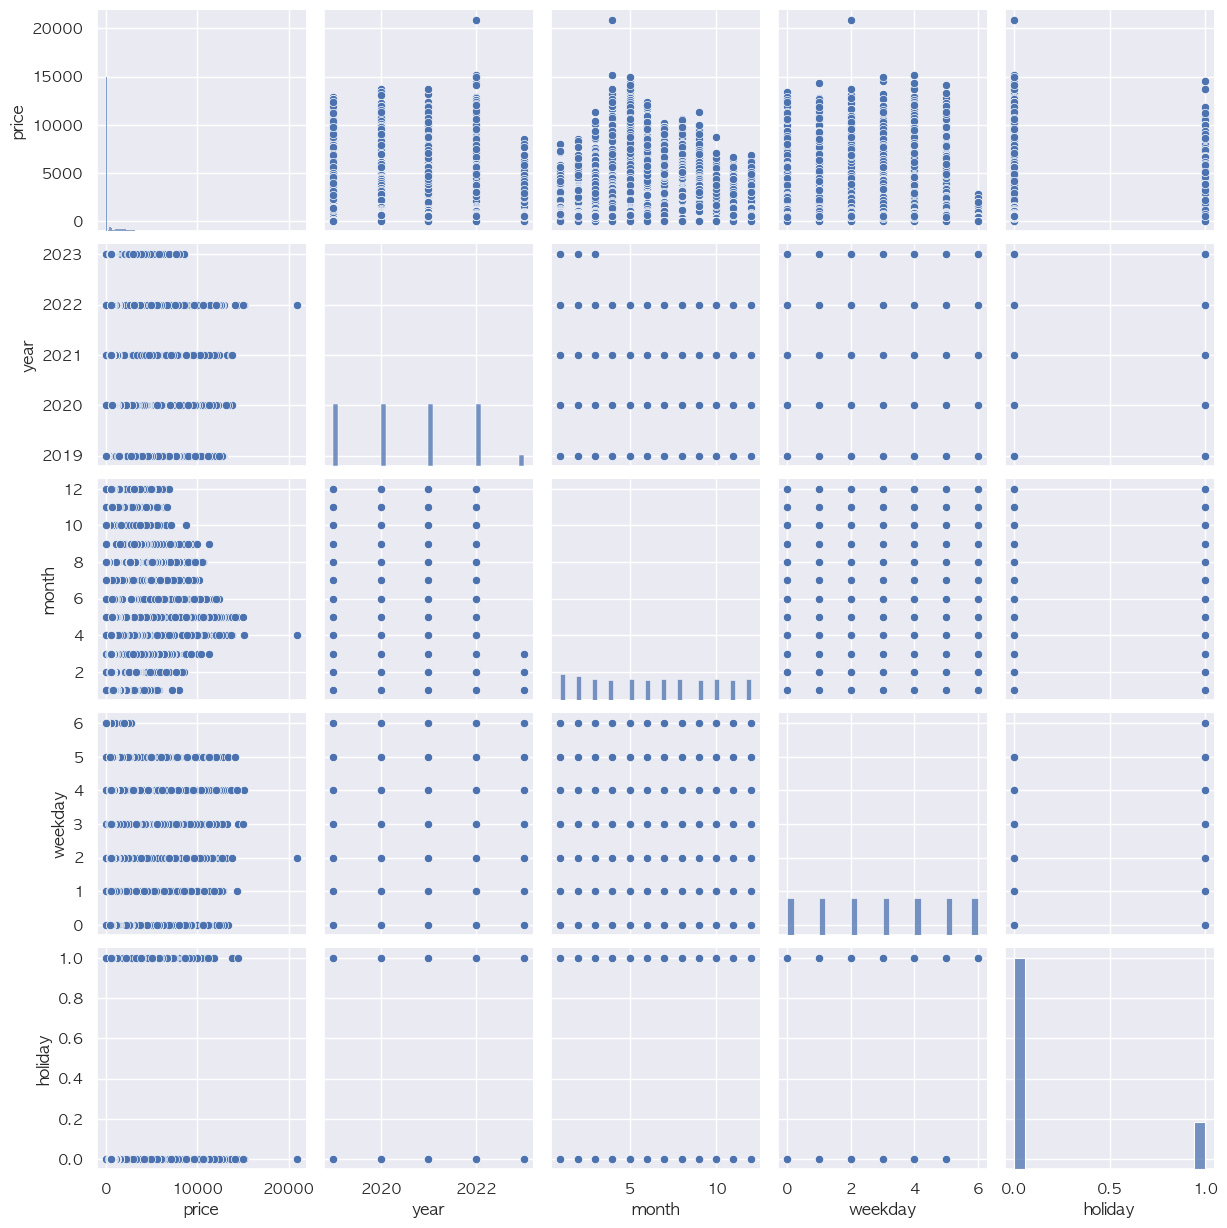

In [63]:
sns.pairplot(train_df[['price', 'year', 'month', 'weekday', 'holiday']])
plt.show()

### 3.4. 전처리

- *결측치 처리*
- *이상치 처리*
- *범주형 변수 수치화*
- *스케일링 적용*
    - *정규화/표준화*

#### 필요없는 변수 제거

In [61]:
train_df.drop(['ymd', 'day'], axis=1, inplace=True)

In [62]:
train_df.head().T

,0,1,2,3,4
ID,TG_A_J_20190101,TG_A_J_20190102,TG_A_J_20190103,TG_A_J_20190104,TG_A_J_20190105
price,0.0,0.0,1728.0,1408.0,1250.0
item,TG,TG,TG,TG,TG
corporation,A,A,A,A,A
location,J,J,J,J,J
year,2019,2019,2019,2019,2019
month,1,1,1,1,1
ts,2019-01-01 00:00:00,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-05 00:00:00
weekday,1,2,3,4,5
holiday,1,0,0,0,0


#### 카테고리 변수 인코딩(Label Encoding)

- 카테고리형 변수들을 LabelEncoder, 각 인코더를 딕셔너리에 저장
- 딕셔너리를 사용하여 추후에 test 데이터 변환 시 사용
- train 데이터 변환하는 함수, test 데이터 변환하는 함수 따로 생성

##### 카테고리 변수 리스트 설정

In [26]:
# 카테고리형 변수 리스트 설정
cat_cols = ['item', 'corporation', 'location',
            'year', 'month', 'weekday', 'holiday']

##### LabelEncoder

In [21]:
def pre_cat_label_encoder(df):
    """카테고리형 변수들을 LabelEncoder로 변환 후, 각 인코더를 딕셔너리에 저장"""
    label_encoders = {}
    for col in cat_cols:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
        
    # pickle로 저장
    pkl.dump(label_encoders, open('label_encoders.pkl', 'wb'))
    return label_encoders


def pre_cat_label_encoder_test(df):
    """test 데이터 변환 시 사용"""
    # pickle로 저장한 label_encoders를 불러와서 정의하기
    label_encoders = pkl.load(open('label_encoders.pkl', 'rb'))
    
    for col in cat_cols:
        try:
            df[col] = label_encoders[col].transform(df[col])
        except:
            print('train에 없는 값이 test에 존재합니다.')
            df[col] = 0

##### OneHotEncoder

- 카테고리형 변수들을 OneHotEncoder로 변환 후 N-1 인코딩을 적용
- 선형회귀 모델인 경우에는 OneHotEncoder를 사용할 시, 공선성 문제가 발생할 수 있음
- 따라서, N-1개의 칼럼만 생성하도록 하는, drop='first' 옵션을 사용


In [22]:
def pre_cat_onehot_encoder(df):
    """카테고리형 변수들을 OneHotEncoder로 변환 후 N-1 인코딩을 적용"""
    onehot_encoders = {}
    for col in cat_cols:
        onehot_encoders[col] = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_data = onehot_encoders[col].fit_transform(df[[col]])
        
        # 원-핫 인코딩된 데이터를 DataFrame으로 변환
        encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoders[col].get_feature_names_out([col]))
        
        # 첫 번째 열(기준 범주)을 제거하여 N-1 인코딩 구현
        encoded_df = encoded_df.iloc[:, 1:]
        
        # 원래 DataFrame에 병합하고, 원본 열 삭제
        df = df.drop(col, axis=1).join(encoded_df)
        
    # pickle로 저장
    pkl.dump(onehot_encoders, open('onehot_encoders.pkl', 'wb'))
    return df, onehot_encoders

def pre_cat_onehot_encoder_test(df):
    """테스트 데이터 변환 시 사용"""
    onehot_encoders = pkl.load(open('onehot_encoders.pkl', 'rb'))
    
    for col in cat_cols:
        try:
            encoded_data = onehot_encoders[col].transform(df[[col]])
            encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoders[col].get_feature_names_out([col]))
            
            # 첫 번째 열(기준 범주)을 제거하여 N-1 인코딩 구현
            encoded_df = encoded_df.iloc[:, 1:]
            
            df = df.drop(col, axis=1).join(encoded_df)
        except:
            print(f'{col} 열에 train에 없는 값이 test에 존재합니다.')
            
    return df

In [69]:
# label_encoders = pre_cat_label_encoder(train_df)

In [70]:
df_last, onhot_encoders = pre_cat_onehot_encoder(train_df)

In [71]:
df_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             59397 non-null  object        
 1   price          59397 non-null  float64       
 2   ts             59397 non-null  datetime64[ns]
 3   item_CB        59397 non-null  float64       
 4   item_CR        59397 non-null  float64       
 5   item_RD        59397 non-null  float64       
 6   item_TG        59397 non-null  float64       
 7   corporation_B  59397 non-null  float64       
 8   corporation_C  59397 non-null  float64       
 9   corporation_D  59397 non-null  float64       
 10  corporation_E  59397 non-null  float64       
 11  corporation_F  59397 non-null  float64       
 12  location_S     59397 non-null  float64       
 13  year_2020      59397 non-null  float64       
 14  year_2021      59397 non-null  float64       
 15  year_2022      5939

In [72]:
train_df.sample(3).T

,17325,15232,15806
ID,CR_B_J_20200726,CR_A_J_20190103,CR_A_J_20200730
price,0.0,0.0,0.0
item,CR,CR,CR
corporation,B,A,A
location,J,J,J
year,2020,2019,2020
month,7,1,7
ts,2020-07-26 00:00:00,2019-01-03 00:00:00,2020-07-30 00:00:00
weekday,6,3,3
holiday,1,0,0


## 4. 모델링

In [34]:
train_df = train_data.copy()
trade_df = trade_data.copy()

In [35]:
train_df = train_df[['ID','price(원/kg)']]
train_df.columns = ['ID','price']

### 4.1. 분류 모델(앙상블)

#### 4.1.1. 전처리 및 피처 엔지니어링 적용

In [36]:
pre_init_feature(train_df)
pre_ymd(train_df)
pre_timestamp(train_df)
pre_weekday(train_df)
pre_holiday(train_df)

train_df, onhot_encoders = pre_cat_onehot_encoder(train_df)

In [37]:
onhot_encoders

{'item': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'corporation': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'location': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'year': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'month': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'weekday': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'holiday': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)}

#### 4.1.2. 데이터 정의

##### Train, Test 세트 분할

In [38]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 37), (546, 37))

##### Train 및 Test Data x, y 설정

In [39]:
# price 값이 0인 경우와 아닌 경우를 분류하는 모델을 위한 데이터셋 설정
# price 값이 0인 경우는 0, 아닌 경우는 1로 설정
train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x == 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x == 0 else 0)

In [40]:
train_x = train_df.drop(['ID', 'price', 'ymd', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['ID', 'price', 'ymd', 'ts'], axis=1)
test_y = test_df['price']

In [41]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (546, 33), (546,))

##### 검증 데이터 분할

In [42]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                                                  test_size=0.2, random_state=42)

In [43]:
print('train shape : ', train_x.shape, train_y.shape)
print('val shape : ', val_x.shape, val_y.shape)
print('test shape : ', test_x.shape, test_y.shape)

train shape :  (47080, 33) (47080,)
val shape :  (11771, 33) (11771,)
test shape :  (546, 33) (546,)


In [54]:
# 분류 모델 정의
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

### 4.1.3. 모델 정의

In [55]:
# 분류 model dict 생성
models = {
    'rf': RandomForestClassifier(n_estimators=100),
    'cat': CatBoostClassifier(n_estimators=100,
                              learning_rate=0.05),
    'xgb': XGBClassifier(n_estimators=100,
                            learning_rate=0.05),
    # 'lgbm': LGBMClassifier(n_estimators=100,
    #                         learning_rate=0.05),
    'lr': LogisticRegression()    
}

In [56]:
# model 학습
for model_name, model in models.items():
    print(model_name)
    try:
        model.fit(train_x, train_y,
                eval_set=[(val_x, val_y)],
                early_stopping_rounds=100,
                verbose=100,
                eval_metric='accuracy')
    except:
        model.fit(train_x, train_y)

rf
cat
0:	learn: 0.6494475	total: 65.1ms	remaining: 6.45s
1:	learn: 0.6141425	total: 68.8ms	remaining: 3.37s
2:	learn: 0.5843857	total: 72.7ms	remaining: 2.35s
3:	learn: 0.5622714	total: 76.4ms	remaining: 1.83s
4:	learn: 0.5338246	total: 79.9ms	remaining: 1.52s
5:	learn: 0.5171396	total: 83.6ms	remaining: 1.31s
6:	learn: 0.4972400	total: 87.4ms	remaining: 1.16s
7:	learn: 0.4795210	total: 92ms	remaining: 1.06s
8:	learn: 0.4673767	total: 96.1ms	remaining: 972ms
9:	learn: 0.4581887	total: 99.8ms	remaining: 899ms
10:	learn: 0.4499634	total: 104ms	remaining: 839ms
11:	learn: 0.4370348	total: 108ms	remaining: 793ms
12:	learn: 0.4274878	total: 112ms	remaining: 750ms
13:	learn: 0.4218082	total: 116ms	remaining: 712ms
14:	learn: 0.4127328	total: 119ms	remaining: 676ms
15:	learn: 0.4081071	total: 123ms	remaining: 647ms
16:	learn: 0.3998485	total: 127ms	remaining: 620ms
17:	learn: 0.3931144	total: 131ms	remaining: 597ms
18:	learn: 0.3869604	total: 135ms	remaining: 575ms
19:	learn: 0.3830678	total

In [57]:
# model val 예측
preds_val = {}
for model_name, model in models.items():
    preds_val[model_name] = model.predict(val_x)

# model test 예측
preds_test = {}
for model_name, model in models.items():
    preds_test[model_name] = model.predict(test_x)

In [58]:
# val, test 분류 모델의 정확도 및 정밀도, 재현율, f1 score 확인
acc_val = {}
f1_val = {}
acc_test = {}
f1_test = {}

In [59]:
# 정확도 및 f1 score 확인
for model_name, pred in preds_val.items():
    acc_val[model_name] = accuracy_score(val_y, pred)
    f1_val[model_name] = f1_score(val_y, pred, average='weighted')
    
for model_name, pred in preds_test.items():
    acc_test[model_name] = accuracy_score(test_y, pred)
    f1_test[model_name] = f1_score(test_y, pred, average='weighted')

In [60]:
pd.DataFrame([acc_val, f1_val, acc_test, f1_test],
                index=['acc_val', 'f1_val', 'acc_test', 'f1_test']).T

,acc_val,f1_val,acc_test,f1_test
rf,0.941211,0.941325,0.906593,0.905293
cat,0.910968,0.911261,0.858974,0.855118
xgb,0.909948,0.910323,0.884615,0.880227
lr,0.883018,0.882911,0.833333,0.830789


### 4.2. 시계열 모델(D-Linear 및 ARIMA)

In [73]:
train_df = train_data.copy()
trade_df = trade_data.copy()

In [74]:
train_df = train_df[['ID','price(원/kg)']]
train_df.columns = ['ID','price']

#### 4.2.1. 전처리 및 피처 엔지니어링 적용

In [75]:
pre_init_feature(train_df)
pre_ymd(train_df)
pre_timestamp(train_df)
pre_weekday(train_df)
pre_holiday(train_df)

label_encoders = pre_cat_label_encoder(train_df)

In [622]:
label_encoders

{'item': LabelEncoder(),
 'corporation': LabelEncoder(),
 'location': LabelEncoder(),
 'year': LabelEncoder(),
 'month': LabelEncoder(),
 'weekday': LabelEncoder(),
 'holiday': LabelEncoder()}

In [623]:
label_encoders['item'].classes_

array(['BC', 'CB', 'CR', 'RD', 'TG'], dtype=object)

In [624]:
label_encoders['item'].inverse_transform([4])

array(['TG'], dtype=object)

In [625]:
label_encoders['corporation'].classes_

array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object)

In [626]:
label_encoders['location'].classes_

array(['J', 'S'], dtype=object)

In [84]:
# label_encoders에서 특정 칼럼의 인코더를 불러오고, inverse_transform으로 디코딩하는 함수
def inverse_transform_label_encoder(col, value):
    return label_encoders[col].inverse_transform([value])[0]

# label_encoders['item'].classes_
# label_encoders['item'].inverse_transform([0, 1, 2, 3, 4])

In [628]:
train_df.sample(3).T

,17325,15232,15806
ID,CR_B_J_20200726,CR_A_J_20190103,CR_A_J_20200730
price,0.0,0.0,0.0
item,2,2,2
corporation,1,0,0
location,0,0,0
ymd,20200726,20190103,20200730
year,1,0,1
month,6,0,6
day,26,3,30
ts,2020-07-26 00:00:00,2019-01-03 00:00:00,2020-07-30 00:00:00


#### 4.2.2. 데이터 정의
- **x, y 정의**
- *학습:검증:평가세트 분할*
- *교차검증방법 적용*

##### Train, Test 세트 분할

- 실제 대회에서는 아래와 같은 기준으로 평가함
  - Public Score: 2023.03.04~2023.03.17의 데이터로 측정
  - Private Score: 2023.03.04~2023.03.31의 데이터로 측정
- 하지만 모델 성능 평가를 위해선 위의 기간의 데이터가 존재하지 않으므로, `train_data`의 일부분(2023년 2월 18일 부터 2023년 3월 3일)을 test 세트로 분할하여 모델 평가 진행하기

> - train : 2019년 01월 01일부터 2023년 2월 17일 까지
> - test : 2023년 2월 18일 부터 2023년 3월 3일까지

In [629]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 12), (546, 12))

##### Train 및 Test Data x, y 설정
- `Y`
  - `price`: 가격

In [78]:
train_df.head()

,ID,price,item,corporation,location,ymd,year,month,day,ts,weekday,holiday
0,TG_A_J_20190101,0.0,4,0,0,20190101,0,0,0,2019-01-01,1,1
1,TG_A_J_20190102,0.0,4,0,0,20190102,0,0,1,2019-01-02,2,0
2,TG_A_J_20190103,1728.0,4,0,0,20190103,0,0,2,2019-01-03,3,0
3,TG_A_J_20190104,1408.0,4,0,0,20190104,0,0,3,2019-01-04,4,0
4,TG_A_J_20190105,1250.0,4,0,0,20190105,0,0,4,2019-01-05,5,0


#### 4.2.3. ARIMA 모델 정의 및 학습

In [631]:
# 같은 item, corporation, location 별 리스트 생성
type_list = train_df.groupby(['item', 'corporation', 'location']).groups.keys()
type_list = list(type_list)

In [635]:
# ID 별 ARIMA 생성 후, 모델을 딕셔너리에 저장 후, 딕셔너리를 pickle로 저장
model_dict = {}
pred_list = []
for i in range(len(type_list)):
    print(i, type_list[i])
    # item, corporation, location 별로 데이터 추출
    temp_df = train_df[(train_df['item'] == type_list[i][0]) &
                       (train_df['corporation'] == type_list[i][1]) &
                       (train_df['location'] == type_list[i][2])]
    
    # TimeSeries 생성
    ts = TimeSeries.from_dataframe(temp_df[['price']].astype('float32'))
    
    # ARIMA 생성
    model = AutoARIMA(start_p=8, max_p=12, start_q=1)
    
    # 학습
    model.fit(ts)
    # 모델을 딕셔너리에 저장
    model_dict[type_list[i]] = model
    # 예측
    future = pd.DataFrame()
    future['arima'] = pd.date_range(start='2023-02-18', periods=14, freq='D')
    forecast = model.predict(len(future['arima']), verbose=False)
    pred_y = forecast.values()
    
    # ID 생성
    item = inverse_transform_label_encoder('item', type_list[i][0])
    corporation = inverse_transform_label_encoder('corporation', type_list[i][1])
    location = inverse_transform_label_encoder('location', type_list[i][2])
    # print(item, corporation, location)
    
    code = '_'.join([item, corporation, location])
    # print(code)
    pred_code = [str(code)] * len(pred_y)
    
    # # ID 뒤에 yyyymmdd 포맷으로 날짜를 붙여줌
    timestamps = future['dlinear'].dt.strftime('%Y%m%d').values

    for id_test, timestamp, y_test in zip(pred_code, timestamps, pred_y):
        pred_list.append({'ID': '_'.join([id_test, timestamp]), 'arima': y_test})

0 (0, 0, 0)


1 (0, 0, 1)
2 (0, 1, 0)
3 (0, 1, 1)
4 (0, 2, 0)
5 (0, 2, 1)
6 (0, 3, 0)
7 (0, 4, 0)
8 (0, 4, 1)
9 (1, 0, 0)
10 (1, 0, 1)
11 (1, 3, 0)
12 (1, 4, 0)
13 (1, 5, 0)
14 (2, 0, 0)
15 (2, 1, 0)
16 (2, 2, 0)
17 (2, 3, 0)
18 (2, 3, 1)
19 (2, 4, 0)
20 (2, 4, 1)
21 (3, 0, 0)
22 (3, 0, 1)
23 (3, 2, 1)
24 (3, 3, 0)
25 (3, 3, 1)
26 (3, 4, 0)
27 (3, 4, 1)
28 (3, 5, 0)
29 (4, 0, 0)
30 (4, 0, 1)
31 (4, 1, 0)
32 (4, 1, 1)
33 (4, 2, 0)
34 (4, 2, 1)
35 (4, 3, 0)
36 (4, 3, 1)
37 (4, 4, 0)
38 (4, 4, 1)


In [643]:
with open('arima_model.pkl', 'wb') as file:
    pkl.dump(model_dict, file)

In [636]:
pred_ARIMA = pd.DataFrame(pred_list)

In [638]:
pred_ARIMA['arima'] = pred_ARIMA['arima'].apply(lambda x : x[0])

In [639]:
# test_df와 pred_DLinear를 ID 기준으로 merge
result_df = pd.merge(test_df, pred_ARIMA, on='ID', how='left')

In [640]:
# # test rmse 계산 저장 및 모델별 성능 표 출력
rmse = np.sqrt(mean_squared_error(result_df['price'], result_df['arima']))
rmse

910.7081893869446

In [641]:
r2 = r2_score(result_df['price'], result_df['arima'])
r2

0.643182375718516

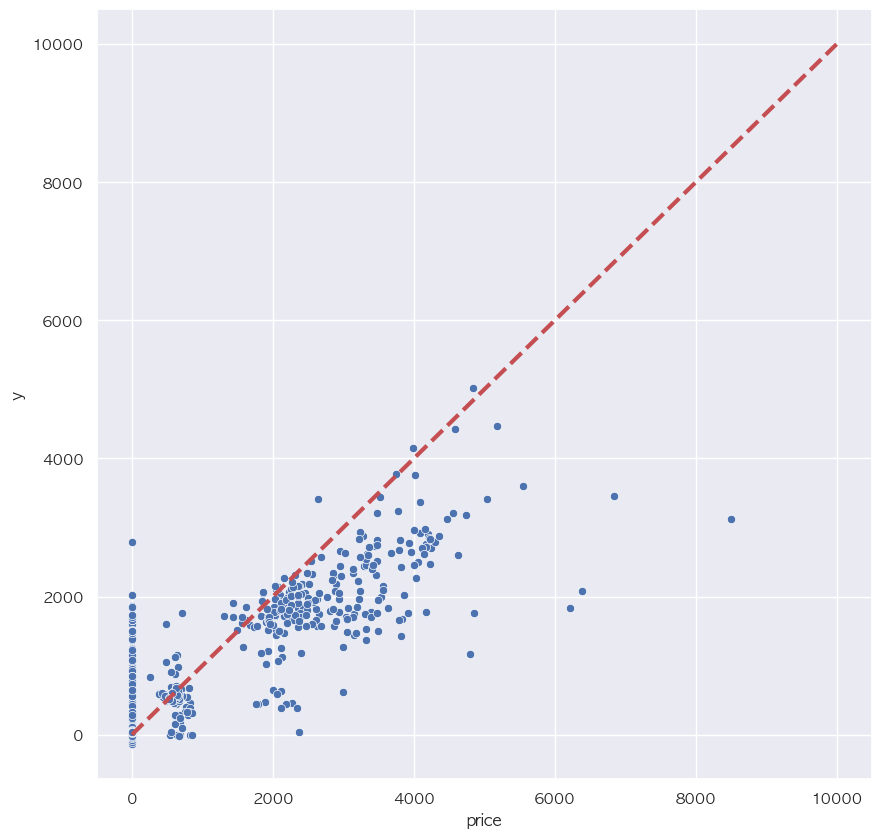

In [642]:
# test 데이터의 실제값과 예측값 비교 시각화, y=x 그래프 추가하기
plt.figure(figsize=(10, 10))
sns.scatterplot(x=result_df['price'], y=result_df['arima'])
plt.plot([0, 10000], [0, 10000], 'r--', linewidth=3)
plt.xlabel('price')
plt.ylabel('y')
plt.show()

#### 4.1.4. D-Linear 모델 정의 및 학습

In [309]:
# 같은 item, corporation, location 별 리스트 생성
type_list = train_df.groupby(['item', 'corporation', 'location']).groups.keys()
type_list = list(type_list)

In [310]:
# ID 별 DLinearModel 생성 후, 모델을 딕셔너리에 저장 후, 딕셔너리를 pickle로 저장
model_dict = {}
pred_list = []
for i in range(len(type_list)):
    # item, corporation, location 별로 데이터 추출
    temp_df = train_df[(train_df['item'] == type_list[i][0]) &
                       (train_df['corporation'] == type_list[i][1]) &
                       (train_df['location'] == type_list[i][2])]
    
    # TimeSeries 생성
    ts = TimeSeries.from_dataframe(temp_df[['price']].astype('float32'))
    
    # DLinearModel 생성
    model = DLinearModel(input_chunk_length=128,
                         output_chunk_length=14,
                         batch_size=256, n_epochs=50
                         )
    
    # 학습
    model.fit(ts, verbose=False)
    # 모델을 딕셔너리에 저장
    model_dict[type_list[i]] = model
    # 예측
    future = pd.DataFrame()
    future['dlinear'] = pd.date_range(start='2023-02-18', periods=14, freq='D')
    forecast = model.predict(len(future['dlinear']), verbose=False)
    pred_y = forecast.values()
    
    # ID 생성
    item = inverse_transform_label_encoder('item', type_list[i][0])
    corporation = inverse_transform_label_encoder('corporation', type_list[i][1])
    location = inverse_transform_label_encoder('location', type_list[i][2])
    # print(item, corporation, location)
    
    code = '_'.join([item, corporation, location])
    # print(code)
    pred_code = [str(code)] * len(pred_y)
    
    # # ID 뒤에 yyyymmdd 포맷으로 날짜를 붙여줌
    timestamps = future['dlinear'].dt.strftime('%Y%m%d').values

    for id_test, timestamp, y_test in zip(pred_code, timestamps, pred_y):
        pred_list.append({'ID': '_'.join([id_test, timestamp]), 'dlinear': y_test})

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, 

In [311]:
with open('dlinear_model.pkl', 'wb') as file:
    pkl.dump(model_dict, file)

In [312]:
pred_DLinear = pd.DataFrame(pred_list)

In [313]:
pred_DLinear['dlinear'] = pred_DLinear['dlinear'].apply(lambda x : x[0])

In [314]:
# test_df와 pred_DLinear를 ID 기준으로 merge
result_df = pd.merge(test_df, pred_DLinear, on='ID', how='left')

In [315]:
result_df.head()

,ID,price,item,corporation,location,ymd,year,month,day,ts,weekday,holiday,dlinear
0,TG_A_J_20230218,2404.0,4,0,0,20230218,4,1,18,2023-02-18,5,0,1872.274658
1,TG_A_J_20230219,0.0,4,0,0,20230219,4,1,19,2023-02-19,6,1,569.389526
2,TG_A_J_20230220,2362.0,4,0,0,20230220,4,1,20,2023-02-20,0,0,1514.013550
3,TG_A_J_20230221,2433.0,4,0,0,20230221,4,1,21,2023-02-21,1,0,1541.971191
4,TG_A_J_20230222,2813.0,4,0,0,20230222,4,1,22,2023-02-22,2,0,1670.639893


In [316]:
# # test rmse 계산 저장 및 모델별 성능 표 출력
rmse = np.sqrt(mean_squared_error(result_df['price'], result_df['dlinear']))
rmse

864.8236506048286

In [317]:
r2 = r2_score(result_df['price'], result_df['dlinear'])
r2

0.6782319420594063

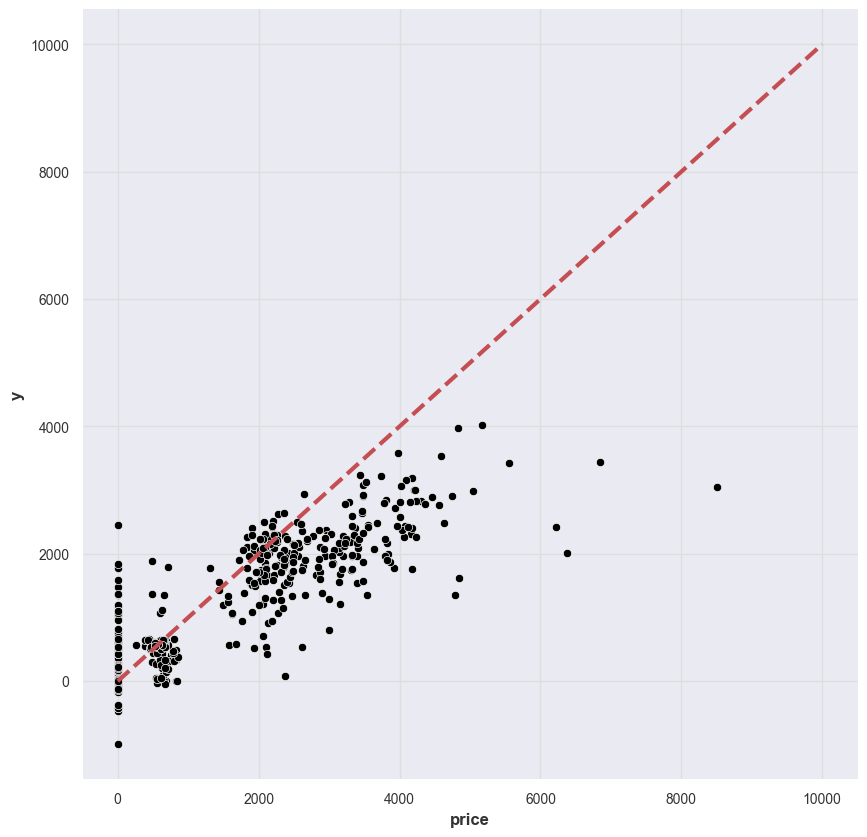

In [318]:
# test 데이터의 실제값과 예측값 비교 시각화, y=x 그래프 추가하기
plt.figure(figsize=(10, 10))
sns.scatterplot(x=result_df['price'], y=result_df['dlinear'])
plt.plot([0, 10000], [0, 10000], 'r--', linewidth=3)
plt.xlabel('price')
plt.ylabel('y')
plt.show()

In [319]:
# result_df의 dlinear 칼럼이 음수인 경우 0으로 변환
result_df['dlinear'] = result_df['dlinear'].apply(lambda x : 0 if x < 0 else x)

In [320]:
# # test rmse, r2 계산 저장 및 모델별 성능 표 출력
rmse = np.sqrt(mean_squared_error(result_df['price'], result_df['dlinear']))
r2 = r2_score(result_df['price'], result_df['dlinear'])
rmse, r2

(862.6891681200351, 0.6798183018291408)

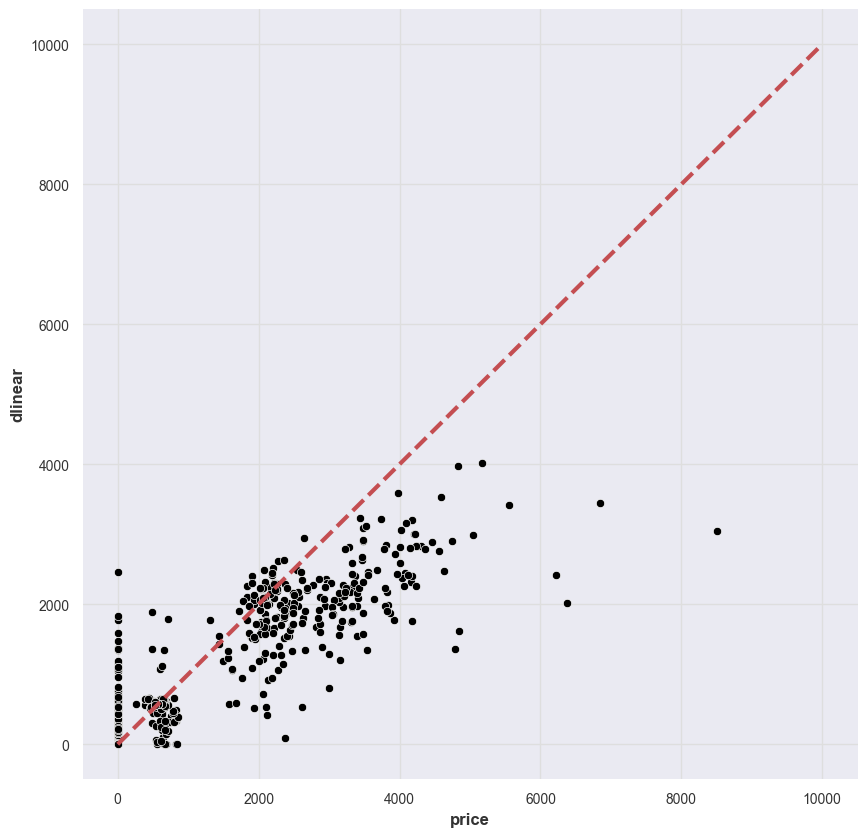

In [321]:
# test 데이터의 실제값과 예측값 비교 시각화, y=x 그래프 추가하기
plt.figure(figsize=(10, 10))
sns.scatterplot(x=result_df['price'], y=result_df['dlinear'])
plt.plot([0, 10000], [0, 10000], 'r--', linewidth=3)
plt.xlabel('price')
plt.ylabel('dlinear')
plt.show()

### 4.3. 예측 모델(앙상블)

In [396]:
train_df = train_data.copy()
trade_df = trade_data.copy()

In [397]:
train_df = train_df[['ID','price(원/kg)']]
train_df.columns = ['ID','price']

#### 4.3.1. 전처리 및 피처 엔지니어링 적용

In [398]:
pre_init_feature(train_df)
pre_ymd(train_df)
pre_timestamp(train_df)
pre_weekday(train_df)
pre_holiday(train_df)

train_df, onhot_encoders = pre_cat_onehot_encoder(train_df)

In [399]:
onhot_encoders

{'item': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'corporation': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'location': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'year': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'month': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'weekday': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'holiday': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)}

In [400]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             59397 non-null  object        
 1   price          59397 non-null  float64       
 2   ymd            59397 non-null  object        
 3   day            59397 non-null  int64         
 4   ts             59397 non-null  datetime64[ns]
 5   item_CB        59397 non-null  float64       
 6   item_CR        59397 non-null  float64       
 7   item_RD        59397 non-null  float64       
 8   item_TG        59397 non-null  float64       
 9   corporation_B  59397 non-null  float64       
 10  corporation_C  59397 non-null  float64       
 11  corporation_D  59397 non-null  float64       
 12  corporation_E  59397 non-null  float64       
 13  corporation_F  59397 non-null  float64       
 14  location_S     59397 non-null  float64       
 15  year_2020      5939

#### 4.3.2. 데이터 정의

##### Train, Test 세트 분할

- 실제 대회에서는 아래와 같은 기준으로 평가함
  - Public Score: 2023.03.04~2023.03.17의 데이터로 측정
  - Private Score: 2023.03.04~2023.03.31의 데이터로 측정
- 하지만 모델 성능 평가를 위해선 위의 기간의 데이터가 존재하지 않으므로, `train_data`의 일부분(2023년 2월 18일 부터 2023년 3월 3일)을 test 세트로 분할하여 모델 평가 진행하기

> - train : 2019년 01월 01일부터 2023년 2월 17일 까지
> - test : 2023년 2월 18일 부터 2023년 3월 3일까지

In [401]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

# train_df에서 price 칼럼이 0인 데이터 제거
# train_df = train_df[train_df['price'] != 0]

train_df.shape, test_df.shape

((58851, 37), (546, 37))

##### Train 및 Test Data x, y 설정

In [402]:
train_df.columns

Index(['ID', 'price', 'ymd', 'day', 'ts', 'item_CB', 'item_CR', 'item_RD',
       'item_TG', 'corporation_B', 'corporation_C', 'corporation_D',
       'corporation_E', 'corporation_F', 'location_S', 'year_2020',
       'year_2021', 'year_2022', 'year_2023', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'holiday_1'],
      dtype='object')

In [403]:
train_x = train_df.drop(['ID', 'price', 'ymd', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['ID', 'price', 'ymd', 'ts'], axis=1)
test_y = test_df['price']

In [404]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (546, 33), (546,))

##### 검증 데이터 분할

In [405]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                                                  test_size=0.2, random_state=42)

In [406]:
print('train shape : ', train_x.shape, train_y.shape)
print('val shape : ', val_x.shape, val_y.shape)
print('test shape : ', test_x.shape, test_y.shape)

train shape :  (47080, 33) (47080,)
val shape :  (11771, 33) (11771,)
test shape :  (546, 33) (546,)


### 4.3.3. 모델 정의

In [94]:
# model dict 생성
models = {
    'xgb': XGBRegressor(n_estimators=1000,
                        learning_rate=0.05),
    'lgbm': LGBMRegressor(n_estimators=1000,
                          learning_rate=0.05),
    'rf': RandomForestRegressor(n_estimators=1000),
    'cat': CatBoostRegressor(n_estimators=1000,
                             learning_rate=0.05,
                             verbose=100),
    'linear': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic': ElasticNet(),
    'sgd': SGDRegressor()
}

### 4.3.4. 모델 학습

- *일반화*
    - *오버피팅/언더피팅*

In [408]:
# model 학습
for model_name, model in models.items():
    print(model_name)
    try:
        model.fit(train_x, train_y,
                eval_set=[(val_x, val_y)],
                early_stopping_rounds=100,
                verbose=100,
                eval_metric='rmse')
    except:
        model.fit(train_x, train_y)

xgb
[0]	validation_0-rmse:2300.97521


[100]	validation_0-rmse:1046.52962
[200]	validation_0-rmse:994.18890
[300]	validation_0-rmse:970.99294
[400]	validation_0-rmse:953.51784
[500]	validation_0-rmse:943.48419
[600]	validation_0-rmse:935.14990
[700]	validation_0-rmse:929.79314
[800]	validation_0-rmse:924.38524
[900]	validation_0-rmse:918.89585
[999]	validation_0-rmse:915.75625
lgbm
[100]	valid_0's rmse: 939.424	valid_0's l2: 882517
[200]	valid_0's rmse: 910.627	valid_0's l2: 829242
[300]	valid_0's rmse: 900.203	valid_0's l2: 810365
[400]	valid_0's rmse: 889.519	valid_0's l2: 791245
[500]	valid_0's rmse: 879.614	valid_0's l2: 773720
[600]	valid_0's rmse: 872.743	valid_0's l2: 761680
[700]	valid_0's rmse: 870.403	valid_0's l2: 757601
[800]	valid_0's rmse: 867.88	valid_0's l2: 753216
[900]	valid_0's rmse: 865.71	valid_0's l2: 749454
[1000]	valid_0's rmse: 863.515	valid_0's l2: 745659
rf
cat
0:	learn: 1963.7172787	total: 2.37ms	remaining: 2.37s
100:	learn: 1131.3267811	total: 166ms	remaining: 1.48s
200:	learn: 1059.2993344	tota

### 4.3.5. 모델 평가 및 검증

In [409]:
# model val 예측
preds_val = {}
for model_name, model in models.items():
    preds_val[model_name] = model.predict(val_x)
    
# model test 예측
preds_test = {}
for model_name, model in models.items():
    preds_test[model_name] = model.predict(test_x)

In [410]:
# val, test의 rmse, r2 계산 저장 및 모델별 성능 표 출력
rmses_val = {}
rmses_test = {}
r2_val = {}
r2_test = {}

In [411]:
for model_name, pred in preds_val.items():
    rmses_val[model_name] = np.sqrt(mean_squared_error(val_y, pred))
    r2_val[model_name] = r2_score(val_y, pred)
for model_name, pred in preds_test.items():
    rmses_test[model_name] = np.sqrt(mean_squared_error(test_y, pred))
    r2_test[model_name] = r2_score(test_y, pred)

In [412]:
pd.DataFrame([rmses_val, rmses_test], index=['rmse_val', 'rmse_test']).T

,rmse_val,rmse_test
xgb,915.756248,828.588162
lgbm,863.515310,858.038253
rf,860.849032,773.985083
cat,950.234400,886.538788
linear,1528.764773,1150.579595
ridge,1528.769558,1150.638292
lasso,1529.056170,1162.785115
elastic,1822.515868,1309.939129
sgd,1535.698505,1177.740953


In [413]:
pd.DataFrame([r2_val, r2_test], index=['r2_val', 'r2_test']).T

,r2_val,r2_test
xgb,0.806283,0.704631
lgbm,0.827754,0.683261
rf,0.828816,0.742277
cat,0.791421,0.661870
linear,0.460129,0.430464
ridge,0.460125,0.430406
lasso,0.459923,0.418317
elastic,0.232724,0.261773
sgd,0.455221,0.403257


In [414]:
# 모델의 개수에 따라 필요한 행의 수를 계산
n_rows = (len(models) + 2) // 3  # 3열을 기준으로 행의 수를 계산

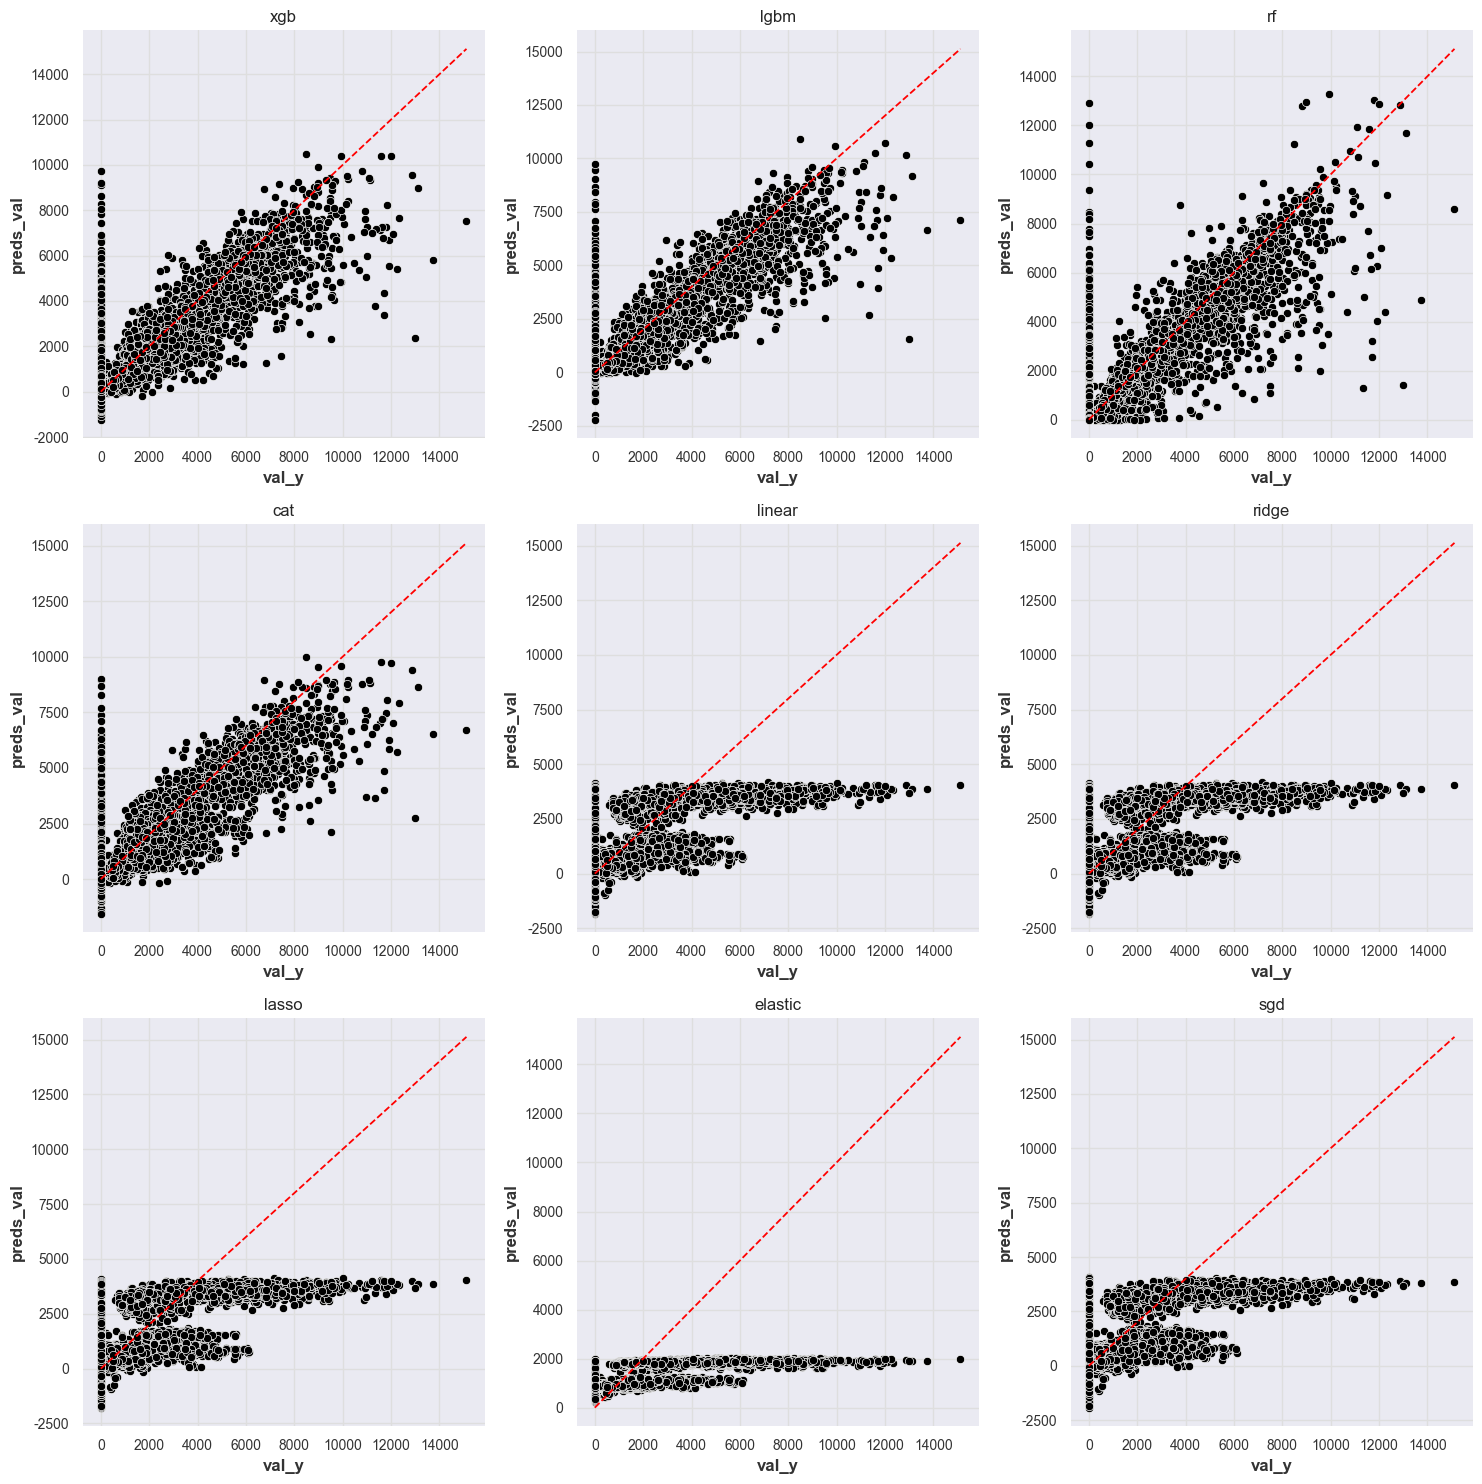

In [415]:
# 모델별 val 데이터의 실제값과 예측값 비교 시각화
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))  # 행과 열 설정
axes = axes.flatten()  # 다차원 배열을 1차원 배열로 변환

for i, model_name in enumerate(models):
    sns.scatterplot(x=val_y, y=preds_val[model_name], ax=axes[i])
    
    axes[i].plot([val_y.min(), val_y.max()],
                 [val_y.min(), val_y.max()],
                 ls='--', c='red')
    axes[i].set_title(model_name)
    axes[i].set_xlabel('val_y')
    axes[i].set_ylabel('preds_val')

# 사용하지 않는 서브플롯을 숨김
for i in range(len(models), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

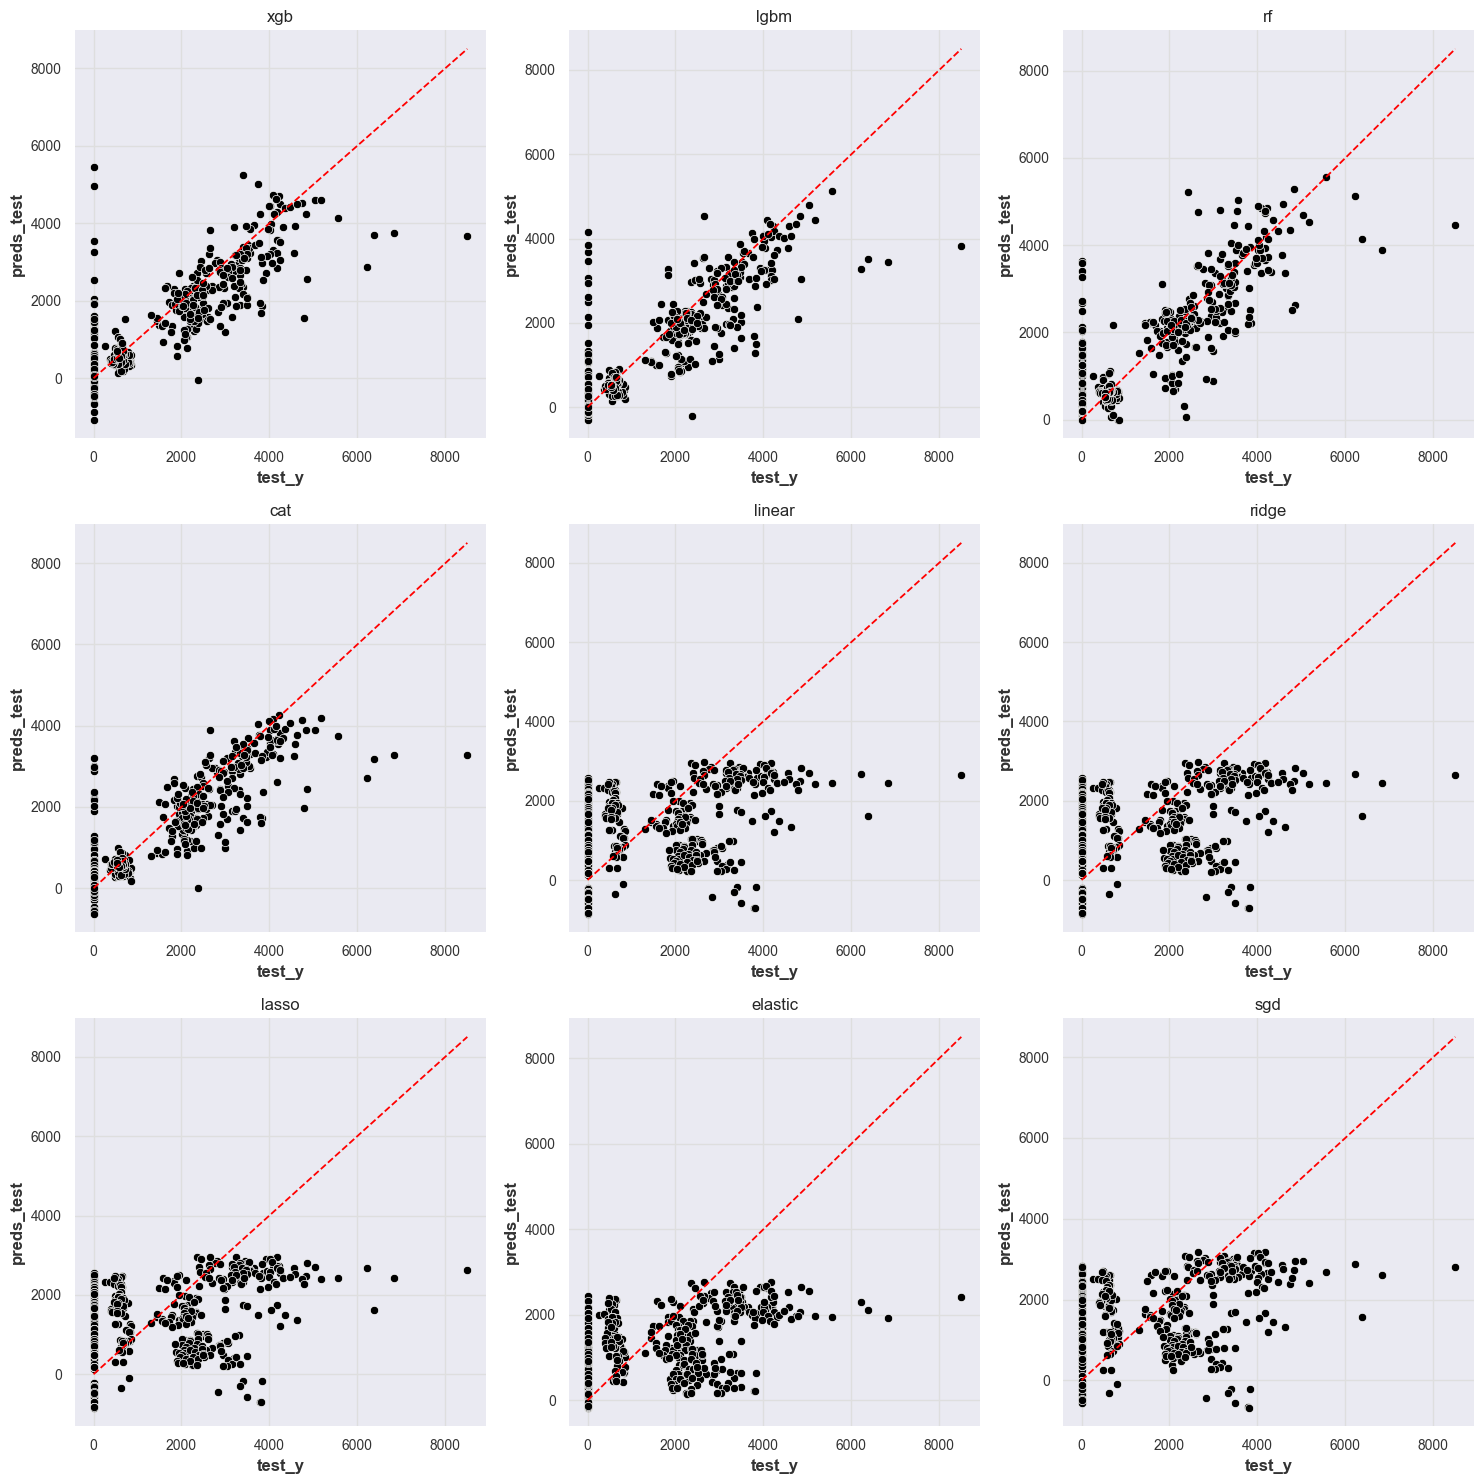

In [123]:
# 모델별 val 데이터의 실제값과 예측값 비교 시각화
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))  # 행과 열 설정
axes = axes.flatten()  # 다차원 배열을 1차원 배열로 변환

for i, model_name in enumerate(models):
    sns.scatterplot(x=test_y, y=preds_test[model_name], ax=axes[i])
    
    axes[i].plot([test_y.min(), test_y.max()],
                 [test_y.min(), test_y.max()],
                 ls='--', c='red')
    axes[i].set_title(model_name)
    axes[i].set_xlabel('test_y')
    axes[i].set_ylabel('preds_test')

# 사용하지 않는 서브플롯을 숨김
for i in range(len(models), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [416]:
preds_val_0 = preds_val.copy()
preds_test_0 = preds_test.copy()

In [417]:
# 에측값 중 음수인 값들을 0으로 변환
for model_name in preds_val_0:
    preds_val_0[model_name][preds_val_0[model_name] < 0] = 0

for model_name in preds_test_0:
    preds_test_0[model_name][preds_test_0[model_name] < 0] = 0

In [418]:
# val, test rmse 계산 저장 및 모델별 성능 표 출력
rmses_val_0 = {}
rmses_test_0 = {}
for model_name, pred in preds_val_0.items():
    rmses_val_0[model_name] = np.sqrt(mean_squared_error(val_y, pred))
for model_name, pred in preds_test_0.items():
    rmses_test_0[model_name] = np.sqrt(mean_squared_error(test_y, pred))

In [419]:
# 예측값 중 음수인 값들을 0으로 변환한 경우와 아닌 경우의 rmse 비교 표
pd.DataFrame([rmses_val, rmses_val_0, rmses_test, rmses_test_0],
             index=['val', 'val_0', 'test', 'test_0']).T

,val,val_0,test,test_0
xgb,915.756248,911.049904,828.588162,819.348427
lgbm,863.515310,860.708915,858.038253,844.008240
rf,860.849032,860.849032,773.985083,773.985083
cat,950.234400,945.210893,886.538788,883.100087
linear,1528.764773,1501.060412,1150.579595,1122.556328
ridge,1528.769558,1501.081206,1150.638292,1122.607842
lasso,1529.056170,1502.531672,1162.785115,1133.021886
elastic,1822.515868,1822.515868,1309.939129,1309.939129
sgd,1535.698505,1500.296342,1177.740953,1139.970810


- 음수를 0으로 변환한 경우가 더 좋은 성능을 보임

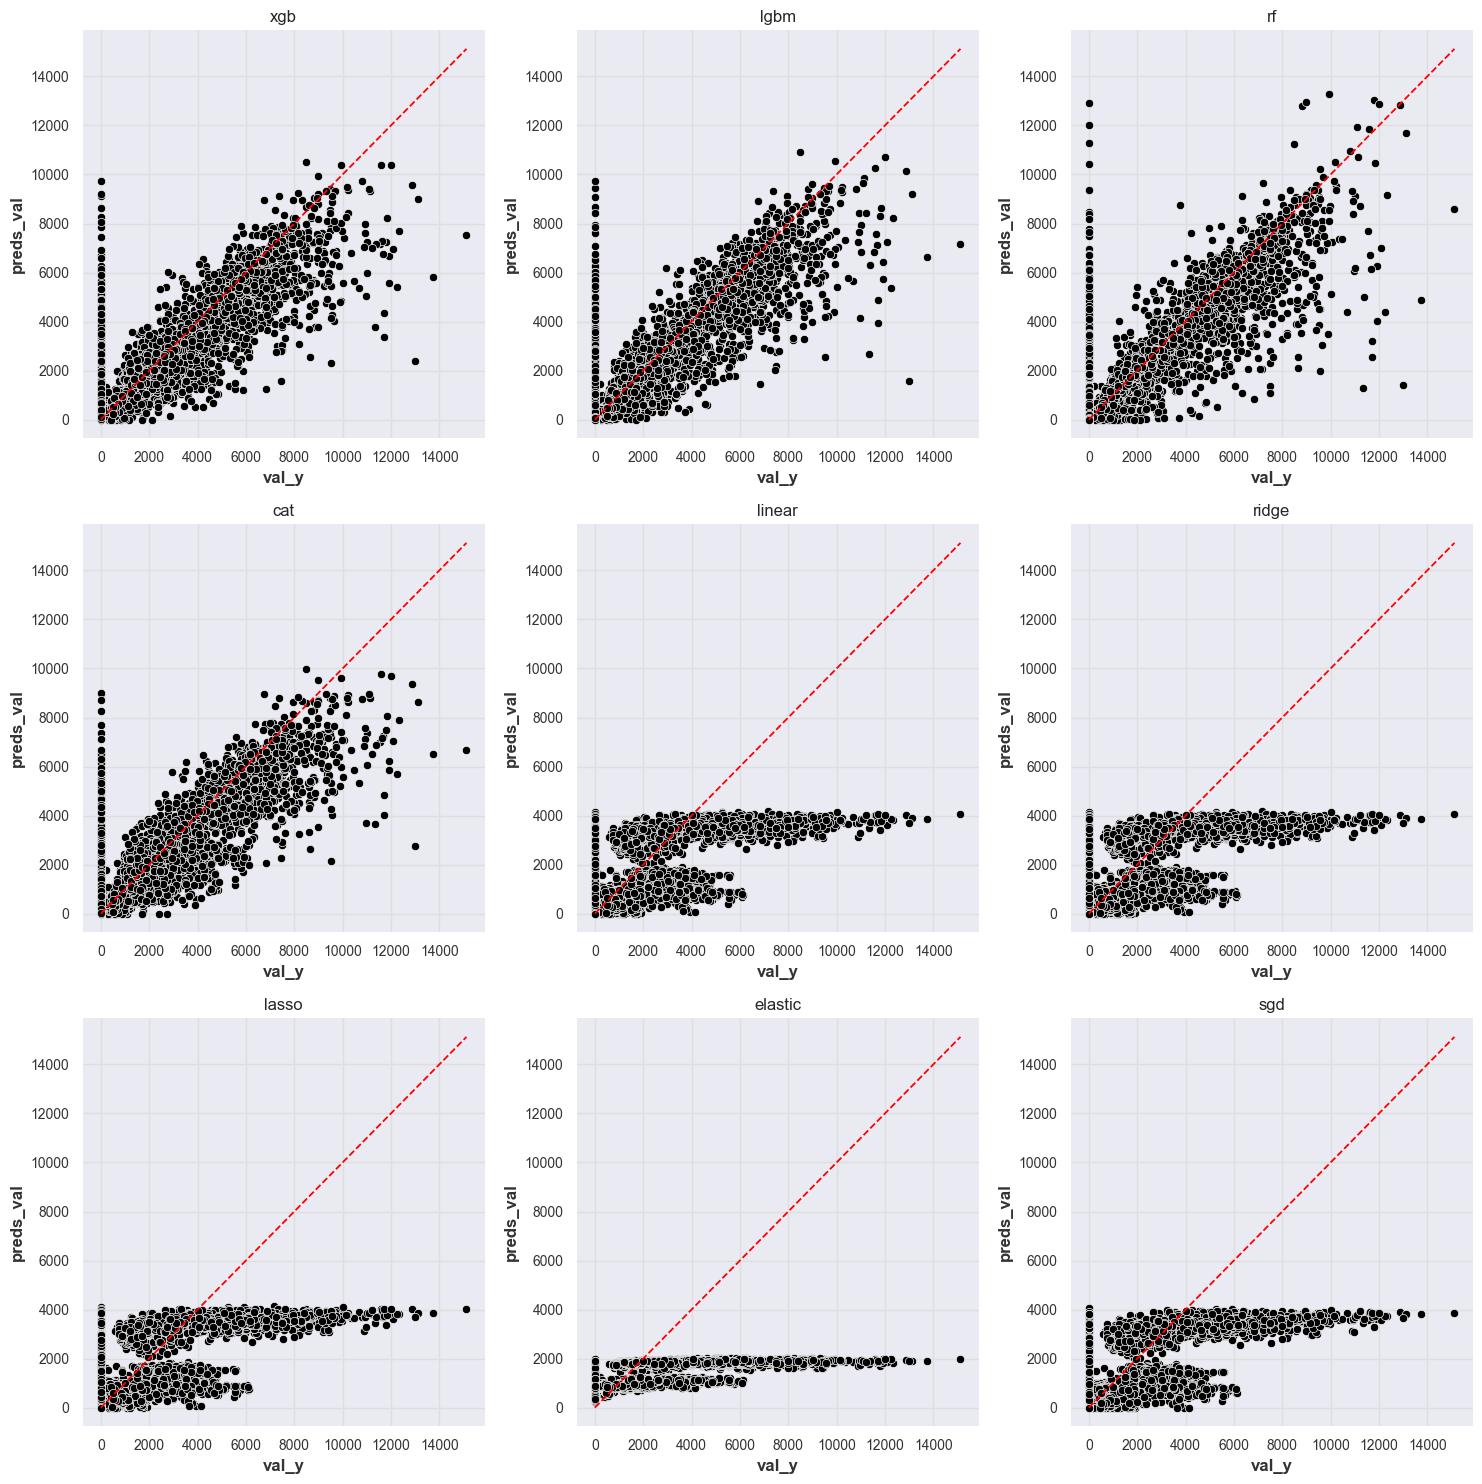

In [421]:
# 모델별 val 데이터의 실제값과 예측값 비교 시각화
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))  # 행과 열 설정
axes = axes.flatten()  # 다차원 배열을 1차원 배열로 변환

for i, model_name in enumerate(models):
    sns.scatterplot(x=val_y, y=preds_val_0[model_name], ax=axes[i])
    
    axes[i].plot([val_y.min(), val_y.max()],
                 [val_y.min(), val_y.max()],
                 ls='--', c='red')
    axes[i].set_title(model_name)
    axes[i].set_xlabel('val_y')
    axes[i].set_ylabel('preds_val')

# 사용하지 않는 서브플롯을 숨김
for i in range(len(models), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

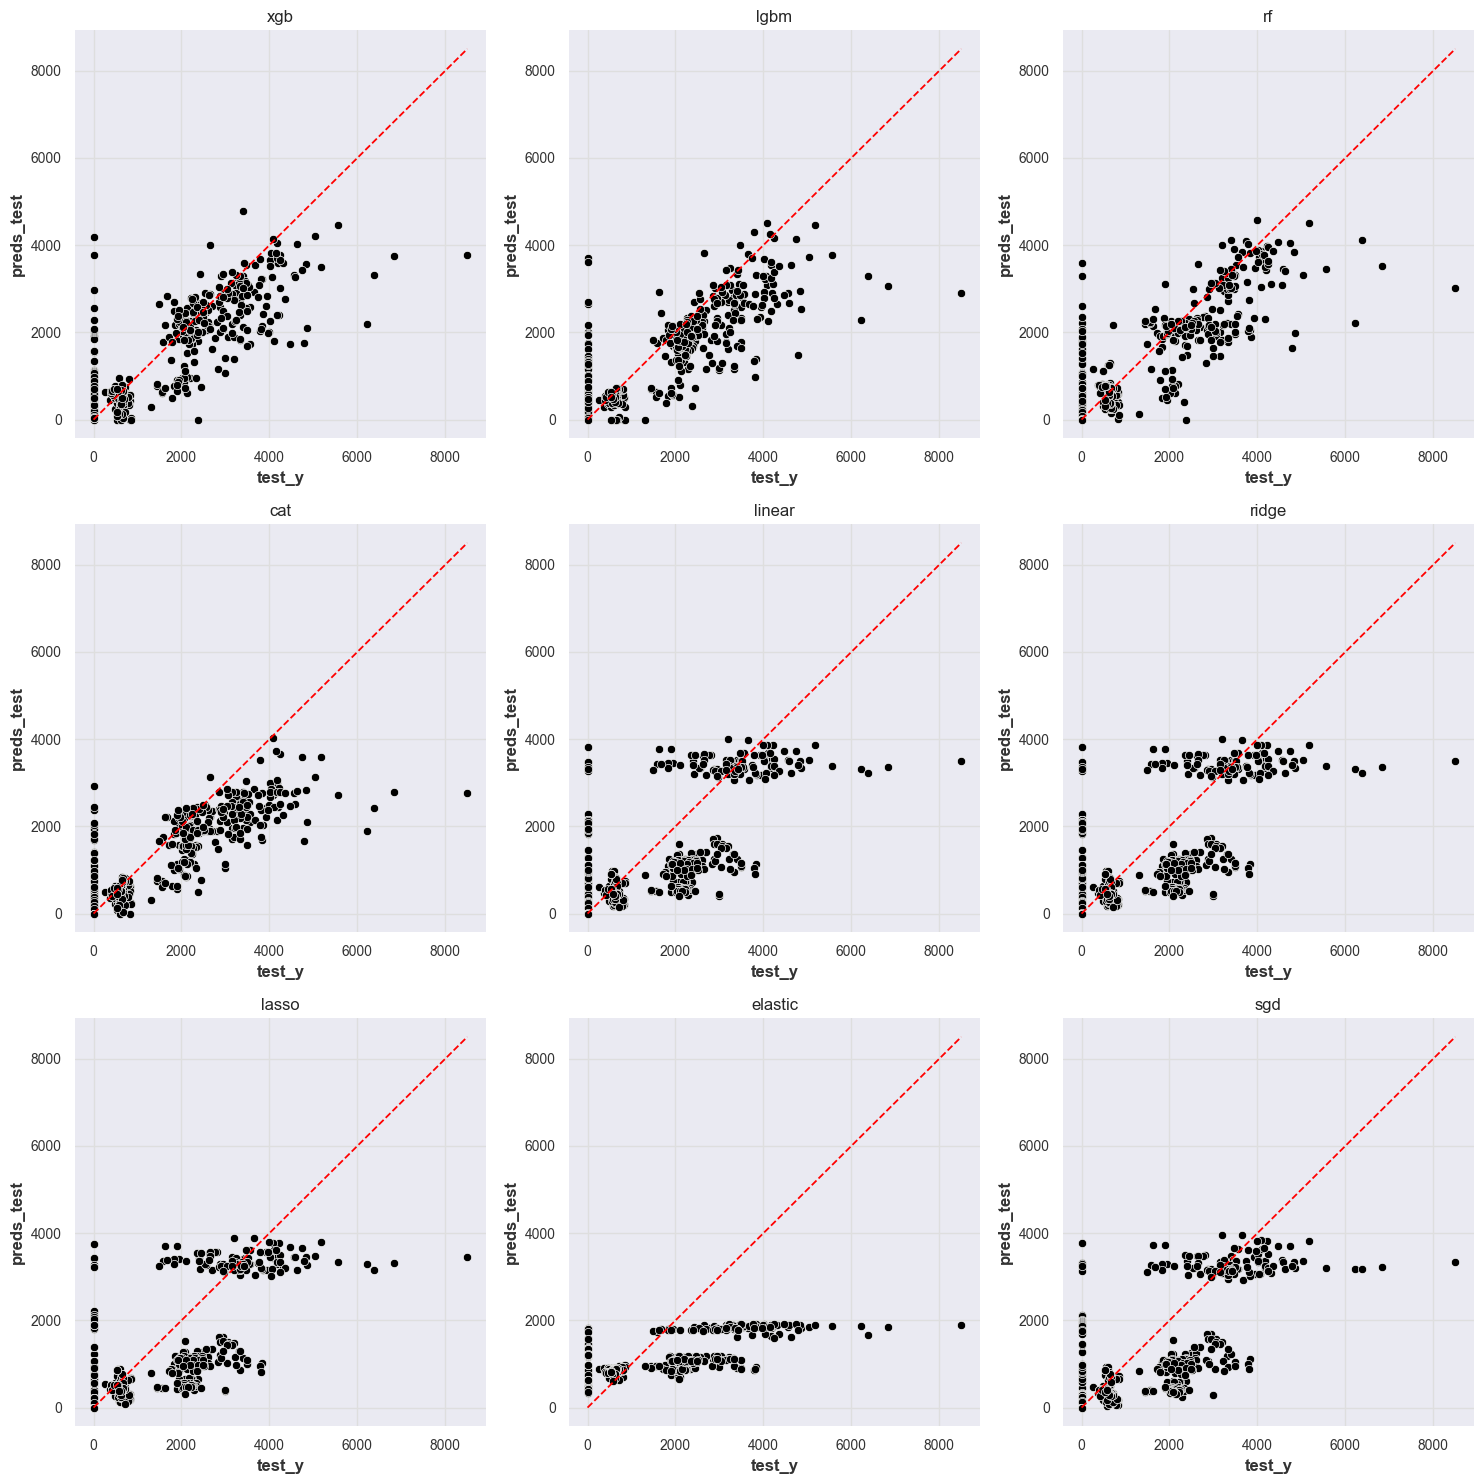

In [422]:
# 모델별 val 데이터의 실제값과 예측값 비교 시각화
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))  # 행과 열 설정
axes = axes.flatten()  # 다차원 배열을 1차원 배열로 변환

for i, model_name in enumerate(models):
    sns.scatterplot(x=test_y, y=preds_test_0[model_name], ax=axes[i])
    
    axes[i].plot([test_y.min(), test_y.max()],
                 [test_y.min(), test_y.max()],
                 ls='--', c='red')
    axes[i].set_title(model_name)
    axes[i].set_xlabel('test_y')
    axes[i].set_ylabel('preds_test')

# 사용하지 않는 서브플롯을 숨김
for i in range(len(models), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

- 실제값이 0인 경우를 모델이 예측하지 못하는 경우가 많음

In [423]:
test_y

1509     2404.0
1510        0.0
1511     2362.0
1512     2433.0
1513     2813.0
          ...  
59392     468.0
59393     531.0
59394     574.0
59395     523.0
59396     529.0
Name: price, Length: 546, dtype: float64

### 4.4. 최종 모델 선정

In [438]:
base_train_df = train_data.copy()

base_train_df = base_train_df[['ID','price(원/kg)']]
base_train_df.columns = ['ID','price']

pre_init_feature(base_train_df)
pre_ymd(base_train_df)
pre_timestamp(base_train_df)
pre_weekday(base_train_df)
pre_holiday(base_train_df)

base_test_df = base_train_df[base_train_df['ts'] >= '2023-02-18']

In [439]:
base_test_df

,ID,price,item,corporation,location,ymd,year,month,day,ts,weekday,holiday
1509,TG_A_J_20230218,2404.0,TG,A,J,20230218,2023,2,18,2023-02-18,5,0
1510,TG_A_J_20230219,0.0,TG,A,J,20230219,2023,2,19,2023-02-19,6,1
1511,TG_A_J_20230220,2362.0,TG,A,J,20230220,2023,2,20,2023-02-20,0,0
1512,TG_A_J_20230221,2433.0,TG,A,J,20230221,2023,2,21,2023-02-21,1,0
1513,TG_A_J_20230222,2813.0,TG,A,J,20230222,2023,2,22,2023-02-22,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,468.0,RD,F,J,20230227,2023,2,27,2023-02-27,0,0
59393,RD_F_J_20230228,531.0,RD,F,J,20230228,2023,2,28,2023-02-28,1,0
59394,RD_F_J_20230301,574.0,RD,F,J,20230301,2023,3,1,2023-03-01,2,1
59395,RD_F_J_20230302,523.0,RD,F,J,20230302,2023,3,2,2023-03-02,3,0


In [440]:
last_preds_test = base_test_df.copy()
last_preds_test = last_preds_test[['ID', 'price', 'holiday']]

In [441]:
for model_name in preds_test:
    last_preds_test[model_name] = preds_test[model_name]

In [442]:
last_preds_test = pd.merge(last_preds_test, result_df[['ID', 'dlinear']], on='ID', how='left')

In [443]:
last_preds_test['rf+dlinear'] = (last_preds_test['rf'] + last_preds_test['dlinear'])/2

In [446]:
# last_preds_test의 holiday 칼럼이 1인 경우 모델 예측 칼럼들의 값을 0으로 변환
# for model_name in last_preds_test.columns[3:]:
#     last_preds_test[model_name] = last_preds_test.apply(
#         lambda x : 0 if x.holiday == 1 else x[model_name], axis=1)

In [447]:
# rf, dlinear 칼럼들의 평균값을 구하여 rf+dlinear 칼럼 생성
last_preds_test['rf+dlinear'] = (last_preds_test['rf'] + last_preds_test['dlinear'])/2

In [448]:
# last_preds_test를 통해 모델별 rmse 계산 및 표 출력
rmses_last_test = {}
r2_last_test = {}
for model_name in last_preds_test.columns[3:]:
    rmses_last_test[model_name] = np.sqrt(mean_squared_error(last_preds_test['price'],
                                                             last_preds_test[model_name]))
    r2_last_test[model_name] = r2_score(last_preds_test['price'],
                                        last_preds_test[model_name])
    
pd.DataFrame([rmses_last_test, r2_last_test], index=['rmses_last_test', 'r2_last_test']).T

,rmses_last_test,r2_last_test
xgb,819.348427,0.711181
lgbm,844.008240,0.693535
rf,773.985083,0.742277
cat,883.100087,0.664488
linear,1122.556328,0.457869
ridge,1122.607842,0.457819
lasso,1133.021886,0.447714
elastic,1309.939129,0.261773
sgd,1139.970810,0.440918
dlinear,862.689168,0.679818


In [473]:
# Random Search CV 설정
rs_space = {
    'max_depth': list(np.arange(10, 100, step=10)) + [None],
    'n_estimators': np.arange(10, 500, step=50),
    'max_features': randint(10, 30),
    'min_samples_leaf': randint(2, 10),
    'min_samples_split': np.arange(8, 20, step=2)
}

In [474]:
rf = RandomForestRegressor()

In [475]:
# Random Search CV 실행
rs_cv = RandomizedSearchCV(rf, rs_space, n_iter=10,
                           scoring='neg_mean_squared_error', cv=5,
                           verbose=1, n_jobs=-1)

In [476]:
rs_cv.fit(train_x, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1616cf5b0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3504300d0>,
                                        'min_samples_split': array([ 8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460])},
                   scoring='neg_mean_squared_error', verbose=1)

In [477]:
rf_best_model = rs_cv.best_estimator_
rf_best_model.fit(train_x, train_y)

RandomForestRegressor(max_depth=30, max_features=19, min_samples_leaf=5,
                      min_samples_split=8, n_estimators=310)

In [62]:
# rfr - 최종

In [65]:
#### 4.3.1. 전처리 및 피처 엔지니어링 적용

In [61]:
train_df = train_data.copy()
trade_df = trade_data.copy()

In [63]:
train_df = train_df[['ID','price(원/kg)']]
train_df.columns = ['ID','price']

In [64]:
pre_init_feature(train_df)
pre_ymd(train_df)
pre_timestamp(train_df)
pre_weekday(train_df)
pre_holiday(train_df)

train_df, onhot_encoders = pre_cat_onehot_encoder(train_df)

In [66]:
#### 4.3.2. 데이터 정의

In [67]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

# train_df에서 price 칼럼이 0인 데이터 제거
# train_df = train_df[train_df['price'] != 0]

train_df.shape, test_df.shape

((58851, 37), (546, 37))

In [68]:
##### Train 및 Test Data x, y 설정

In [69]:
train_x = train_df.drop(['ID', 'price', 'ymd', 'ts'], axis=1)
train_y = train_df['price']

test_x = test_df.drop(['ID', 'price', 'ymd', 'ts'], axis=1)
test_y = test_df['price']

In [70]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((58851, 33), (58851,), (546, 33), (546,))

In [72]:
### 4.3.3. 모델 정의

In [73]:
# model dict 생성
models = {
    # 'xgb': XGBRegressor(n_estimators=1000,
    #                     learning_rate=0.05),
    # 'lgbm': LGBMRegressor(n_estimators=1000,
    #                       learning_rate=0.05),
    'rf': RandomForestRegressor(n_estimators=1000),
    # 'cat': CatBoostRegressor(n_estimators=1000,
    #                          learning_rate=0.05,
    #                          verbose=100),
    'linear': LinearRegression(),
    # 'ridge': Ridge(),
    # 'lasso': Lasso(),
    # 'elastic': ElasticNet(),
    # 'sgd': SGDRegressor()
}

In [74]:
### 4.3.4. 모델 학습

In [75]:
# model 학습
for model_name, model in models.items():
    print(model_name)
    try:
        model.fit(train_x, train_y,
                eval_set=[(val_x, val_y)],
                early_stopping_rounds=100,
                verbose=100,
                eval_metric='rmse')
    except:
        model.fit(train_x, train_y)

rf
linear


In [ ]:
### 4.3.5. 모델 평가 및 검증

In [76]:
# model val 예측
preds_val = {}
for model_name, model in models.items():
    preds_val[model_name] = model.predict(val_x)
    
# model test 예측
preds_test = {}
for model_name, model in models.items():
    preds_test[model_name] = model.predict(test_x)

In [77]:
# val, test의 rmse, r2 계산 저장 및 모델별 성능 표 출력
rmses_val = {}
rmses_test = {}
r2_val = {}
r2_test = {}

In [78]:
for model_name, pred in preds_val.items():
    rmses_val[model_name] = np.sqrt(mean_squared_error(val_y, pred))
    r2_val[model_name] = r2_score(val_y, pred)
for model_name, pred in preds_test.items():
    rmses_test[model_name] = np.sqrt(mean_squared_error(test_y, pred))
    r2_test[model_name] = r2_score(test_y, pred)

In [80]:
pd.DataFrame([rmses_val, rmses_test, r2_val, r2_test],
             index=['rmse_val', 'rmse_test', 'r2_val', 'r2_test']).T

,rmse_val,rmse_test,r2_val,r2_test
rf,2297.741036,767.710204,-2.190976e+07,0.746439
linear,1785.945322,1156.403311,-1.323646e+07,0.424684


In [ ]:
# 목적 함수 정의
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'n_estimators': int(params['n_estimators'])+1,
              'max_features': params['max_features'],
              'min_samples_leaf': int(params['min_samples_leaf']),
              'min_samples_split': int(params['min_samples_split'])}
    rf_model = RandomForestRegressor(**params)
    score = -cross_val_score(rf_model, train_x, train_y, scoring='neg_mean_squared_error', cv=5).mean()
    return {'loss': score, 'status': STATUS_OK}

# 탐색 공간 정의
space = {
    'max_depth': hp.quniform('max_depth', 10, 100, 10),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 50),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 8, 20, 2)
}

# 최적화 실행
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# 최적 파라미터로 모델 훈련
best_params = {'max_depth': int(best['max_depth']),
               'n_estimators': int(best['n_estimators']),
               'max_features': best['max_features'],
               'min_samples_leaf': int(best['min_samples_leaf']),
               'min_samples_split': int(best['min_samples_split'])}
rf_best_model = RandomForestRegressor(**best_params)
rf_best_model.fit(train_x, train_y)

print("최적의 하이퍼파라미터:", best_params)

In [482]:
# 목적 함수 정의
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'n_estimators': int(params['n_estimators'])+1,
              'max_features': params['max_features'],
              'min_samples_leaf': int(params['min_samples_leaf']),
              'min_samples_split': int(params['min_samples_split'])}
    rf_model = RandomForestRegressor(**params)
    score = -cross_val_score(rf_model, train_x, train_y, scoring='neg_mean_squared_error', cv=5).mean()
    return {'loss': score, 'status': STATUS_OK}

# 탐색 공간 정의
space = {
    'max_depth': hp.quniform('max_depth', 10, 100, 10),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 50),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 8, 20, 2)
}

# 최적화 실행
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# 최적 파라미터로 모델 훈련
best_params = {'max_depth': int(best['max_depth']),
               'n_estimators': int(best['n_estimators']),
               'max_features': best['max_features'],
               'min_samples_leaf': int(best['min_samples_leaf']),
               'min_samples_split': int(best['min_samples_split'])}
rf_best_model = RandomForestRegressor(**best_params)
rf_best_model.fit(train_x, train_y)

print("최적의 하이퍼파라미터:", best_params)

100%|██████████| 100/100 [1:16:13<00:00, 45.73s/trial, best loss: 722622.3236918574]  
최적의 하이퍼파라미터: {'max_depth': 30, 'n_estimators': 200, 'max_features': 0.8020473445392062, 'min_samples_leaf': 3, 'min_samples_split': 8}


In [487]:
best_params

{'max_depth': 30,
 'n_estimators': 200,
 'max_features': 0.8020473445392062,
 'min_samples_leaf': 3,
 'min_samples_split': 8}

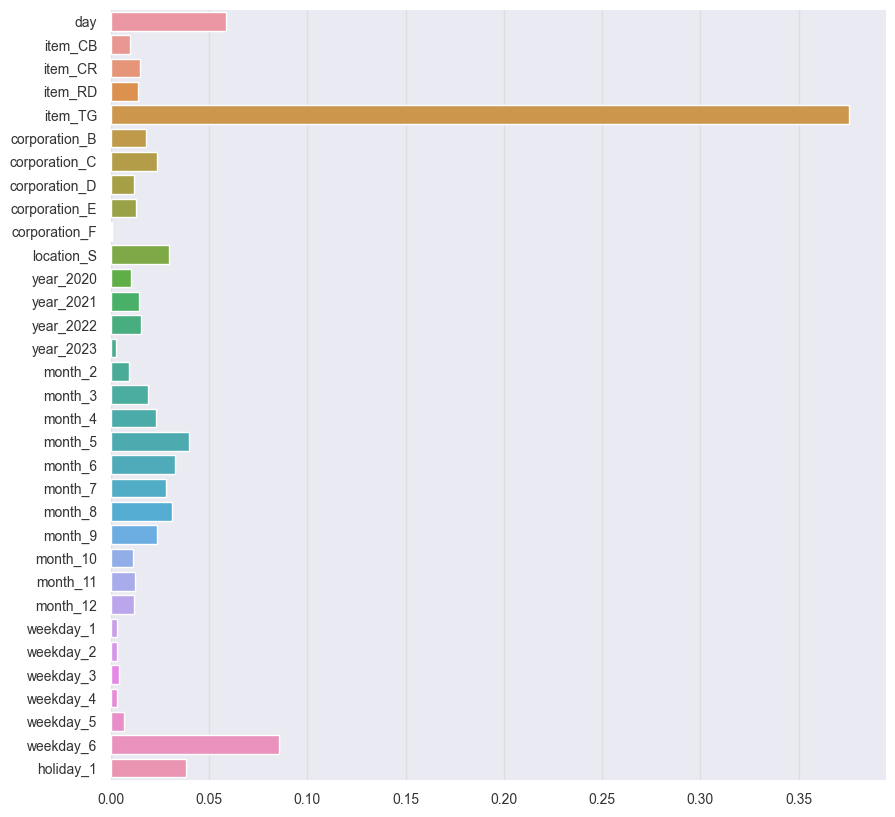

In [505]:
# rf_best_model의 칼럼별 중요도를 시각화
plt.figure(figsize=(10, 10))
sns.barplot(x=rf_best_model.feature_importances_, y=train_x.columns)
plt.show()

In [486]:
# 모델 저장
with open('best_rf_model.pkl', 'wb') as file:
    pkl.dump(rf_best_model, file)

In [459]:
# 모델 불러오기
with open('best_rf_model.pkl', 'rb') as file:
    rf_best_model = pkl.load(file)

In [488]:
# 테스트 데이터에 적용
pred = rf_best_model.predict(test_x)

In [493]:
last_preds_test['rf_best'] = pred

In [494]:
last_preds_test['rf_best+dlinear'] = (last_preds_test['rf_best'] + last_preds_test['dlinear'])/2

In [495]:
# last_preds_test를 통해 모델별 rmse 계산 및 표 출력
rmses_last_test = {}
r2_last_test = {}
for model_name in last_preds_test.columns[3:]:
    rmses_last_test[model_name] = np.sqrt(mean_squared_error(last_preds_test['price'],
                                                             last_preds_test[model_name]))
    r2_last_test[model_name] = r2_score(last_preds_test['price'],
                                        last_preds_test[model_name])
    
pd.DataFrame([rmses_last_test, r2_last_test], index=['rmses_last_test', 'r2_last_test']).T

,rmses_last_test,r2_last_test
xgb,819.348427,0.711181
lgbm,844.008240,0.693535
rf,773.985083,0.742277
cat,883.100087,0.664488
linear,1122.556328,0.457869
ridge,1122.607842,0.457819
lasso,1133.021886,0.447714
elastic,1309.939129,0.261773
sgd,1139.970810,0.440918
dlinear,862.689168,0.679818


In [501]:
last_preds_test_0 = last_preds_test[last_preds_test['price'] != 0]

# last_preds_test를 통해 모델별 rmse 계산 및 표 출력
rmses_last_test = {}
r2_last_test = {}
for model_name in last_preds_test_0.columns[3:]:
    rmses_last_test[model_name] = np.sqrt(mean_squared_error(last_preds_test_0['price'],
                                                             last_preds_test_0[model_name]))
    r2_last_test[model_name] = r2_score(last_preds_test_0['price'],
                                        last_preds_test_0[model_name])
    
score_df = pd.DataFrame([rmses_last_test, r2_last_test], index=['rmses_last_test', 'r2_last_test']).T

In [502]:
# 값 별로 정렬
score_df.sort_values(by='rmses_last_test')

,rmses_last_test,r2_last_test
rf_best,801.924318,0.637439
rf,828.167537,0.613321
xgb,867.398045,0.575819
rf_best+dlinear,873.776934,0.569557
rf+dlinear,879.385325,0.564014
lgbm,924.393761,0.518242
cat,996.640143,0.439996
dlinear,1033.911533,0.397328
linear,1126.027643,0.285154
ridge,1126.275941,0.284839


## 5. 시스템 구현

-  *모델링을 통해 나온 결과를 정의한 문제와 연결하여 해결*
    - *예측, 추론 등의 결과를 활용해 시스템을 구현*

### 5.1. 설계 및 구현

### 5.2. 시스템 테스트 및 운영

## 6. 평가 및 전개


### 6.1. 모델 발전 계획


### 6.2. 인사이트

In [548]:
rmses_last_val

NameError: name 'rmses_last_val' is not defined